<a href="https://colab.research.google.com/github/By-Xin/Autoloss/blob/main/qpth_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
######## VERSION 0.0.1 ########

import torch
from qpth.qp import QPFunction

# 参数定义
n, d = 10, 3  # 数据点数和模型参数维度
L, H = 2, 2   # ReLU 和 ReHU 项数
lambda_reg = 0.1  # Ridge 正则化参数

# 生成示例数据
X_train = torch.randn(n, d)  # 输入数据，形状 (n, d)
y_train = torch.randn(n)     # 目标值，形状 (n,)

# 固定 beta（假设已通过内层优化计算）
beta_star = torch.abs(torch.randn(d))  # 确保 beta >= 0

# 初始化超参数（u_l, v_l, s_h, t_h）
U = torch.randn(L, requires_grad=True)  # u_l，形状 (L,)
V = torch.randn(L, requires_grad=True)  # v_l，形状 (L,)
S = torch.randn(H, requires_grad=True)  # s_h，形状 (H,)
T = torch.randn(H, requires_grad=True)  # t_h，形状 (H,)
tau = torch.ones(H, requires_grad=False)  # T_h 固定为 1，形状 (H,)

def solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg):
    """
    重建内层 QP，用于计算 beta 对超参数的隐式导数
    """
    # QP 参数
    total_vars = d + L * n + H * n + H * n  # [beta, pi, theta, sigma]
    Q = torch.zeros(total_vars)
    Q[:d] = lambda_reg  # beta 的 Ridge 正则化
    Q[d + L * n:d + L * n + H * n] = 1.0  # theta 的二次项
    Q = torch.diag(Q).unsqueeze(0)

    p = torch.zeros(total_vars)
    tau_expanded = tau.repeat(n)  # 形状 (H * n,)
    p[d + L * n + H * n:] = tau_expanded  # sigma 的线性项
    p = p.unsqueeze(0)

    # 约束 G z <= h
    G_rows = 2 * L * n + 2 * H * n + d  # 每样本 2L + 2H + d 个约束
    G = torch.zeros(G_rows, total_vars)
    h_values = torch.zeros(G_rows)  # 临时存储 h 的值

    # pi_li >= u_l (y_i - x_i^T beta) + v_l
    idx = 0
    for i in range(n):
        for l in range(L):
            G[idx, :d] = U[l] * X[i]  # u_l x_i^T beta，保持计算图
            G[idx, d + l * n + i] = -1.0  # -pi_li
            h_values[idx] = U[l] * y[i] + V[l]  # u_l y_i + v_l，保持计算图
            idx += 1

    # pi_li >= 0
    for i in range(n):
        for l in range(L):
            G[idx, d + l * n + i] = -1.0  # -pi_li <= 0
            h_values[idx] = 0.0
            idx += 1

    # theta_hi + sigma_hi >= s_h (y_i - x_i^T beta) + t_h
    for i in range(n):
        for h in range(H):
            G[idx, :d] = S[h] * X[i]  # s_h x_i^T beta，保持计算图
            G[idx, d + L * n + h * n + i] = -1.0  # -theta_hi
            G[idx, d + L * n + H * n + h * n + i] = -1.0  # -sigma_hi
            h_values[idx] = S[h] * y[i] + T[h]  # s_h y_i + t_h，保持计算图
            idx += 1

    # sigma_hi >= 0
    for i in range(n):
        for h in range(H):
            G[idx, d + L * n + H * n + h * n + i] = -1.0  # -sigma_hi <= 0
            h_values[idx] = 0.0
            idx += 1

    # beta_j >= 0
    for j in range(d):
        G[idx, j] = -1.0  # -beta_j <= 0
        h_values[idx] = 0.0
        idx += 1

    G = G.unsqueeze(0)
    h = h_values.unsqueeze(0)  # 转换为 (1, G_rows) 形状

    # 确保 Q 是 SPD
    Q += 1e-4 * torch.eye(total_vars).unsqueeze(0)

    # 使用 qpth 求解
    z = QPFunction(verbose=False)(Q, p, G, h, torch.Tensor(), torch.Tensor())
    beta = z[:, :d].squeeze(0)  # 提取 beta
    return beta

def compute_outer_gradients(beta_star, X, y, U, V, S, T, tau, lambda_reg):
    """
    固定 beta_star，计算外层损失对超参数的导数
    返回：U, V, S, T 的梯度和外层损失值
    """
    # 重建内层 QP，确保 beta 对超参数的依赖
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)

    # 外层损失（MSE）
    y_pred = X @ beta_opt
    L_outer = (1/n) * (y - y_pred).pow(2).sum()

    # 计算外层损失的梯度（隐式微分）
    L_outer.backward()

    # 提取超参数梯度
    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)

    # 清零梯度（添加保护）
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()

    return U_grad, V_grad, S_grad, T_grad, L_outer.item()

# 简单实验：初始化超参数，计算导数，进行一步梯度下降
if __name__ == "__main__":
    # 初始超参数
    print("初始超参数：")
    print(f"U: {U}")
    print(f"V: {V}")
    print(f"S: {S}")
    print(f"T: {T}")

    # 计算外层损失对超参数的导数
    U_grad, V_grad, S_grad, T_grad, outer_loss = compute_outer_gradients(
        beta_star, X_train, y_train, U, V, S, T, tau, lambda_reg
    )

    # 打印导数
    print("\n超参数导数：")
    print(f"U_grad: {U_grad}")
    print(f"V_grad: {V_grad}")
    print(f"S_grad: {S_grad}")
    print(f"T_grad: {T_grad}")
    print(f"外层损失 (MSE): {outer_loss:.4f}")

    # 进行一步梯度下降
    learning_rate = 0.01
    with torch.no_grad():
        U_new = U - learning_rate * U_grad
        V_new = V - learning_rate * V_grad
        S_new = S - learning_rate * S_grad
        T_new = T - learning_rate * T_grad

    # 更新超参数
    U = U_new.clone().requires_grad_(True)
    V = V_new.clone().requires_grad_(True)
    S = S_new.clone().requires_grad_(True)
    T = T_new.clone().requires_grad_(True)

    # 打印优化后的超参数
    print("\n优化后超参数（一步梯度下降）：")
    print(f"U: {U}")
    print(f"V: {V}")
    print(f"S: {S}")
    print(f"T: {T}")

    # 验证 beta 是否保持不变（重新计算 QP 解）
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X_train, y_train, lambda_reg)
    print(f"\n重新计算的 beta: {beta_opt}")
    print(f"原 beta_star: {beta_star}")
    print(f"约束满足情况 (beta >= 0): {torch.all(beta_opt >= 0)}")

初始超参数：
U: tensor([-2.6461,  1.8845], requires_grad=True)
V: tensor([-0.5992, -0.2085], requires_grad=True)
S: tensor([-1.1804, -1.2868], requires_grad=True)
T: tensor([-0.4024, -0.3870], requires_grad=True)

超参数导数：
U_grad: tensor([ 5.4043e-05, -7.2844e-05])
V_grad: tensor([-1.0317e-05,  9.5653e-06])
S_grad: tensor([-0.0459, -0.0548])
T_grad: tensor([0.0507, 0.0550])
外层损失 (MSE): 1.3661

优化后超参数（一步梯度下降）：
U: tensor([-2.6461,  1.8845], requires_grad=True)
V: tensor([-0.5992, -0.2085], requires_grad=True)
S: tensor([-1.1799, -1.2862], requires_grad=True)
T: tensor([-0.4029, -0.3876], requires_grad=True)

重新计算的 beta: tensor([5.1909e-09, 9.3970e-09, 4.4165e-01], grad_fn=<SqueezeBackward1>)
原 beta_star: tensor([1.1445, 0.4805, 1.3974])
约束满足情况 (beta >= 0): True


Outer Step [10/100], Loss=0.839117
Outer Step [20/100], Loss=0.839117
Outer Step [30/100], Loss=0.839117
Outer Step [40/100], Loss=0.839116
Outer Step [50/100], Loss=0.839116
Outer Step [60/100], Loss=0.839116
Outer Step [70/100], Loss=0.839115
Outer Step [80/100], Loss=0.839116
Outer Step [90/100], Loss=0.839115
Outer Step [100/100], Loss=0.839115

训练结束后超参数：
U_final: tensor([-0.5017, -0.3759], requires_grad=True)
V_final: tensor([-1.7347,  0.7506], requires_grad=True)
S_final: tensor([-1.8341, -0.4401], requires_grad=True)
T_final: tensor([ 0.3242, -0.3840], requires_grad=True)


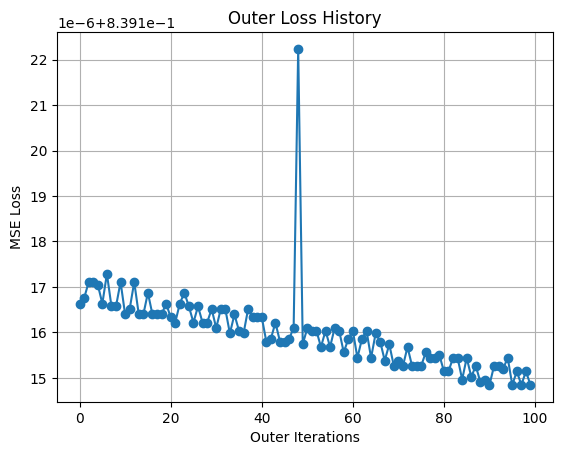

In [9]:
######## VERSION 0.1.0 ########
# 对代码进行了重构 (待检验)

import torch
from qpth.qp import QPFunction

def build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg):
    """
    构建 Q, p, G, h 矩阵。
    """
    n, d = X.shape
    L = U.shape[0]
    H = S.shape[0]

    total_vars = d + L*n + 2*H*n  # [beta, pi, theta, sigma]

    #--------------------#
    #    1) 构建 Q
    #--------------------#
    Q_diag = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    Q_diag[:d] = lambda_reg  # beta正则
    Q_diag[d + L*n : d + L*n + H*n] = 1.0   # theta部分
    Q_diag[d + L*n + H*n : ] = 1.0          # sigma部分

    Q = torch.diag(Q_diag).unsqueeze(0)

    #--------------------#
    #    2) 构建 p
    #--------------------#
    p = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    p[d + L*n + H*n : ] = tau.repeat(n)
    p = p.unsqueeze(0)

    #--------------------#
    #   3) 构建 G, h
    #--------------------#
    G_rows = 2*L*n + 2*H*n + d
    G = torch.zeros(G_rows, total_vars, dtype=X.dtype, device=X.device)
    h_val = torch.zeros(G_rows, dtype=X.dtype, device=X.device)

    row_idx = 0

    # (a) pi_li >= U[l]*(y[i] - x[i]^T beta) + V[l]
    #     => -pi_li + U[l]*x[i]^T beta <= U[l]*y[i] + V[l]
    for i in range(n):
        for l in range(L):
            G[row_idx, :d] = U[l] * X[i]
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = U[l]*y[i] + V[l]
            row_idx += 1

    # (b) pi_li >= 0 => -pi_li <= 0
    for i in range(n):
        for l in range(L):
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # (c) theta_hi + sigma_hi >= S[h]*(y[i] - x[i]^T beta) + T[h]
    #     => -theta_hi - sigma_hi + S[h]*x[i]^T beta <= S[h]*y[i] + T[h]
    for i in range(n):
        for h_ in range(H):
            G[row_idx, :d] = S[h_] * X[i]
            G[row_idx, d + L*n + h_*n + i] = -1.0   # theta
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0  # sigma
            h_val[row_idx] = S[h_]*y[i] + T[h_]
            row_idx += 1

    # (d) sigma_hi >= 0 => -sigma_hi <= 0
    for i in range(n):
        for h_ in range(H):
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # (e) beta_j >= 0 => -beta_j <= 0
    for j in range(d):
        G[row_idx, j] = -1.0
        h_val[row_idx] = 0.0
        row_idx += 1

    G = G.unsqueeze(0)
    h = h_val.unsqueeze(0)

    #--------------------#
    #   数值稳定修正
    #--------------------#
    eps = 1e-4
    Q = Q + eps * torch.eye(total_vars, dtype=X.dtype, device=X.device).unsqueeze(0)

    return Q, p, G, h

def solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg):
    """
    给定超参数(U, V, S, T, tau)，构建并求解内层QP，返回 beta_opt。
    """
    Q, p, G, h = build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg)
    z = QPFunction(verbose=False)(Q, p, G, h, torch.empty(0), torch.empty(0))
    d = X.shape[1]
    beta_opt = z[:, :d].squeeze(0)
    return beta_opt

def compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg):
    """
    1) 基于给定超参数解内层 QP 得到 beta_opt
    2) 计算外层损失(例如 MSE)，反向传播
    3) 收集对超参数的梯度并返回
    """
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)
    n = X.shape[0]
    y_pred = X @ beta_opt
    # 外层损失: MSE
    loss_outer = (1.0/n) * (y - y_pred).pow(2).sum()

    # 反向传播
    loss_outer.backward()

    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)

    # 梯度清零（很重要：避免下次 backward 时不断累加）
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()

    return {
        "beta_opt": beta_opt.detach().clone(),
        "loss": loss_outer.item(),
        "U_grad": U_grad,
        "V_grad": V_grad,
        "S_grad": S_grad,
        "T_grad": T_grad
    }

def train_hyperparams(X, y, U, V, S, T, tau, lambda_reg,
                      lr=1e-2, outer_steps=50):
    """
    多轮外层迭代：在每一步里
      (1) 固定(U, V, S, T)求解内层QP得到 beta_opt
      (2) 计算 outer_loss 并 backward
      (3) 用梯度更新超参数
    返回：更新后的 (U, V, S, T) 以及每一步的损失日志
    """
    loss_history = []

    for step in range(outer_steps):
        # 计算外层损失及梯度
        results = compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg)
        loss_val = results["loss"]
        U_grad, V_grad = results["U_grad"], results["V_grad"]
        S_grad, T_grad = results["S_grad"], results["T_grad"]

        # 梯度下降更新超参数
        with torch.no_grad():
            U -= lr * U_grad
            V -= lr * V_grad
            S -= lr * S_grad
            T -= lr * T_grad

        # 继续保留 requires_grad
        U.requires_grad_(True)
        V.requires_grad_(True)
        S.requires_grad_(True)
        T.requires_grad_(True)

        # 记录损失
        loss_history.append(loss_val)

        # 可以选择打印或记录日志
        if (step+1) % 10 == 0:
            print(f"Outer Step [{step+1}/{outer_steps}], Loss={loss_val:.6f}")

    return U, V, S, T, loss_history
import matplotlib.pyplot as plt

def plot_loss_history(loss_history):
    """
    绘制外层训练过程中 MSE 损失的变化曲线。

    参数：
        loss_history (list or array): 每轮外层训练的损失值列表。
    """
    plt.figure()
    plt.plot(loss_history, marker='o', linestyle='-')
    plt.xlabel("Outer Iterations")
    plt.ylabel("MSE Loss")
    plt.title("Outer Loss History")
    plt.grid(True)
    plt.show()


def main():
    # 数据初始化
    n, d = 100, 3
    L, H = 2, 2
    lambda_reg = 0.1

    X = torch.randn(n, d)
    y = torch.randn(n)

    # 超参数初始化
    U = torch.randn(L, requires_grad=True)
    V = torch.randn(L, requires_grad=True)
    S = torch.randn(H, requires_grad=True)
    T = torch.randn(H, requires_grad=True)
    tau = torch.ones(H, requires_grad=False)

    # 多步外层训练
    U_final, V_final, S_final, T_final, loss_history = train_hyperparams(
        X, y, U, V, S, T, tau, lambda_reg,
        lr=1e-3,    # 学习率
        outer_steps=100  # 外层迭代步数，可以自行调大
    )

    # 观察最终结果
    print("\n训练结束后超参数：")
    print(f"U_final: {U_final}")
    print(f"V_final: {V_final}")
    print(f"S_final: {S_final}")
    print(f"T_final: {T_final}")

    # 如有需要，也可再打印或分析 loss_history
    # print("\nLoss 历史:", loss_history)
    plot_loss_history(loss_history)

if __name__ == "__main__":
    main()


In [11]:
######## DEMO ########
# 用来检验 qpth 能否在 GPU 上运行 -> 可以

import torch
from qpth.qp import QPFunction

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 构造一个简单的 QP 问题
n_vars = 5
Q = torch.eye(n_vars, device=device).unsqueeze(0)
p = torch.zeros(n_vars, device=device).unsqueeze(0)
G = -torch.eye(n_vars, device=device).unsqueeze(0)
h = torch.zeros(n_vars, device=device).unsqueeze(0)

# 构造空张量作为等式约束参数
A = torch.empty(0, device=device)
b = torch.empty(0, device=device)

qp_func = QPFunction(verbose=False)
z = qp_func(Q, p, G, h, A, b)
print("Solution device:", z.device)


Using device: cuda
Solution device: cuda:0


Using device: cuda
Outer Step [10/100], Loss=0.808537
Outer Step [20/100], Loss=0.808537
Outer Step [30/100], Loss=0.808536
Outer Step [40/100], Loss=0.808536
Outer Step [50/100], Loss=0.808100
Outer Step [60/100], Loss=0.808535
Outer Step [70/100], Loss=0.808535
Outer Step [80/100], Loss=0.808535
Outer Step [90/100], Loss=0.808529
Outer Step [100/100], Loss=0.808528

训练结束后超参数：
U_final: tensor([-1.2682, -0.0383], device='cuda:0', requires_grad=True)
V_final: tensor([ 1.4640, -0.3238], device='cuda:0', requires_grad=True)
S_final: tensor([-1.7241,  0.2751], device='cuda:0', requires_grad=True)
T_final: tensor([0.7826, 1.3969], device='cuda:0', requires_grad=True)


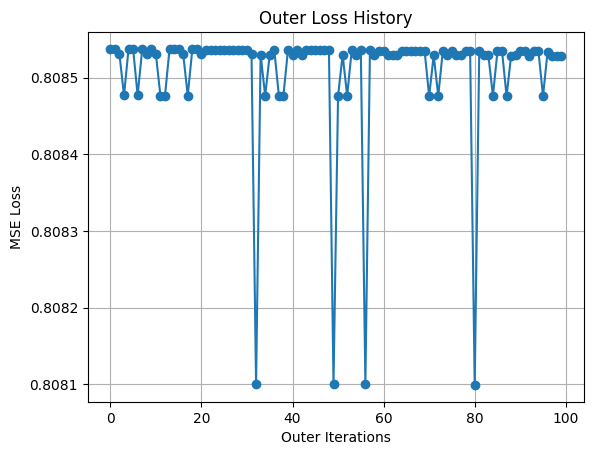

In [18]:
######## VERSION 0.1.1 ########
# 将模型移动到 GPU 上. 对于大规模训练有益

import torch
from qpth.qp import QPFunction
import matplotlib.pyplot as plt

def build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg):
    """
    构建 Q, p, G, h 矩阵。
    """
    n, d = X.shape
    L = U.shape[0]
    H = S.shape[0]

    total_vars = d + L*n + 2*H*n  # [beta, pi, theta, sigma]

    #--------------------#
    #    1) 构建 Q
    #--------------------#
    Q_diag = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    Q_diag[:d] = lambda_reg  # beta正则
    Q_diag[d + L*n : d + L*n + H*n] = 1.0   # theta部分
    Q_diag[d + L*n + H*n : ] = 1.0          # sigma部分

    Q = torch.diag(Q_diag).unsqueeze(0)

    #--------------------#
    #    2) 构建 p
    #--------------------#
    p = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    p[d + L*n + H*n : ] = tau.repeat(n)
    p = p.unsqueeze(0)

    #--------------------#
    #   3) 构建 G, h
    #--------------------#
    G_rows = 2*L*n + 2*H*n + d
    G = torch.zeros(G_rows, total_vars, dtype=X.dtype, device=X.device)
    h_val = torch.zeros(G_rows, dtype=X.dtype, device=X.device)

    row_idx = 0

    # (a) pi_li >= U[l]*(y[i] - x[i]^T beta) + V[l]
    #     => -pi_li + U[l]*x[i]^T beta <= U[l]*y[i] + V[l]
    for i in range(n):
        for l in range(L):
            G[row_idx, :d] = U[l] * X[i]
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = U[l]*y[i] + V[l]
            row_idx += 1

    # (b) pi_li >= 0 => -pi_li <= 0
    for i in range(n):
        for l in range(L):
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # (c) theta_hi + sigma_hi >= S[h]*(y[i] - x[i]^T beta) + T[h]
    #     => -theta_hi - sigma_hi + S[h]*x[i]^T beta <= S[h]*y[i] + T[h]
    for i in range(n):
        for h_ in range(H):
            G[row_idx, :d] = S[h_] * X[i]
            G[row_idx, d + L*n + h_*n + i] = -1.0   # theta
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0  # sigma
            h_val[row_idx] = S[h_]*y[i] + T[h_]
            row_idx += 1

    # (d) sigma_hi >= 0 => -sigma_hi <= 0
    for i in range(n):
        for h_ in range(H):
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # (e) beta_j >= 0 => -beta_j <= 0
    for j in range(d):
        G[row_idx, j] = -1.0
        h_val[row_idx] = 0.0
        row_idx += 1

    G = G.unsqueeze(0)
    h = h_val.unsqueeze(0)

    #--------------------#
    #   数值稳定修正
    #--------------------#
    eps = 1e-4
    Q = Q + eps * torch.eye(total_vars, dtype=X.dtype, device=X.device).unsqueeze(0)

    return Q, p, G, h

def solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg):
    """
    给定超参数(U, V, S, T, tau)，构建并求解内层QP，返回 beta_opt。
    """
    Q, p, G, h = build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg)
    z = QPFunction(verbose=False)(Q, p, G, h, torch.empty(0, device=X.device), torch.empty(0, device=X.device))
    d = X.shape[1]
    beta_opt = z[:, :d].squeeze(0)
    return beta_opt

def compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg):
    """
    1) 基于给定超参数解内层 QP 得到 beta_opt
    2) 计算外层损失(例如 MSE)，反向传播
    3) 收集对超参数的梯度并返回
    """
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)
    n = X.shape[0]
    y_pred = X @ beta_opt
    # 外层损失: MSE
    loss_outer = (1.0/n) * (y - y_pred).pow(2).sum()

    # 反向传播
    loss_outer.backward()

    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)

    # 梯度清零（避免下一次累加）
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()

    return {
        "beta_opt": beta_opt.detach().clone(),
        "loss": loss_outer.item(),
        "U_grad": U_grad,
        "V_grad": V_grad,
        "S_grad": S_grad,
        "T_grad": T_grad
    }

def train_hyperparams(X, y, U, V, S, T, tau, lambda_reg,
                      lr=1e-2, outer_steps=50):
    """
    多轮外层迭代：在每一步里
      (1) 固定(U, V, S, T)求解内层QP得到 beta_opt
      (2) 计算 outer_loss 并 backward
      (3) 用梯度更新超参数
    返回：更新后的 (U, V, S, T) 以及每一步的损失日志
    """
    loss_history = []

    for step in range(outer_steps):
        # 计算外层损失及梯度
        results = compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg)
        loss_val = results["loss"]
        U_grad, V_grad = results["U_grad"], results["V_grad"]
        S_grad, T_grad = results["S_grad"], results["T_grad"]

        # 梯度下降更新超参数
        with torch.no_grad():
            U -= lr * U_grad
            V -= lr * V_grad
            S -= lr * S_grad
            T -= lr * T_grad

        # 保持 requires_grad=True，以继续反向传播
        U.requires_grad_(True)
        V.requires_grad_(True)
        S.requires_grad_(True)
        T.requires_grad_(True)

        # 记录损失
        loss_history.append(loss_val)

        # 打印日志(可选)
        if (step+1) % 10 == 0:
            print(f"Outer Step [{step+1}/{outer_steps}], Loss={loss_val:.6f}")

    return U, V, S, T, loss_history

def plot_loss_history(loss_history):
    """
    绘制外层训练过程中 MSE 损失的变化曲线。
    """
    plt.figure()
    plt.plot(loss_history, marker='o', linestyle='-')
    plt.xlabel("Outer Iterations")
    plt.ylabel("MSE Loss")
    plt.title("Outer Loss History")
    plt.grid(True)
    plt.show()

def main():
    # 指定设备：GPU 优先，否则 CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # 数据初始化 (在CPU生成，然后转移到device)
    n, d = 100, 3
    L, H = 2, 2
    lambda_reg = 0.1

    X = torch.randn(n, d).to(device)
    y = torch.randn(n).to(device)

    # 超参数初始化并放到 device
    U = torch.randn(L, device=device, requires_grad=True)
    V = torch.randn(L, device=device, requires_grad=True)
    S = torch.randn(H, device=device, requires_grad=True)
    T = torch.randn(H, device=device, requires_grad=True)
    tau = torch.ones(H, device=device, requires_grad=False)

    # 多步外层训练
    U_final, V_final, S_final, T_final, loss_history = train_hyperparams(
        X, y, U, V, S, T, tau, lambda_reg,
        lr=1e-3,        # 学习率可调整
        outer_steps=100 # 外层迭代步数
    )

    # 打印最终结果
    print("\n训练结束后超参数：")
    print(f"U_final: {U_final}")
    print(f"V_final: {V_final}")
    print(f"S_final: {S_final}")
    print(f"T_final: {T_final}")

    # 绘制损失曲线
    plot_loss_history(loss_history)

if __name__ == "__main__":
    main()


Using device: cuda
X shape: torch.Size([50, 4]) y shape: torch.Size([50])
Outer Step [10/500], Loss=16.876684
Outer Step [20/500], Loss=16.818695
Outer Step [30/500], Loss=16.788534
Outer Step [40/500], Loss=16.769684
Outer Step [50/500], Loss=16.757063
Outer Step [60/500], Loss=16.748007
Outer Step [70/500], Loss=16.741310
Outer Step [80/500], Loss=16.736433
Outer Step [90/500], Loss=16.732859
Outer Step [100/500], Loss=16.729944
Outer Step [110/500], Loss=16.727541
Outer Step [120/500], Loss=16.725574
Outer Step [130/500], Loss=16.723833
Outer Step [140/500], Loss=16.722410
Outer Step [150/500], Loss=16.721203
Outer Step [160/500], Loss=16.720282
Outer Step [170/500], Loss=16.719469
Outer Step [180/500], Loss=16.718794

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check 

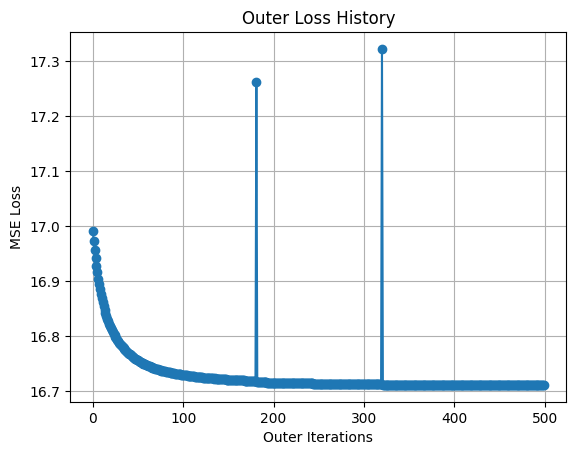

[Final Model] Evaluation MSE: 16.711512


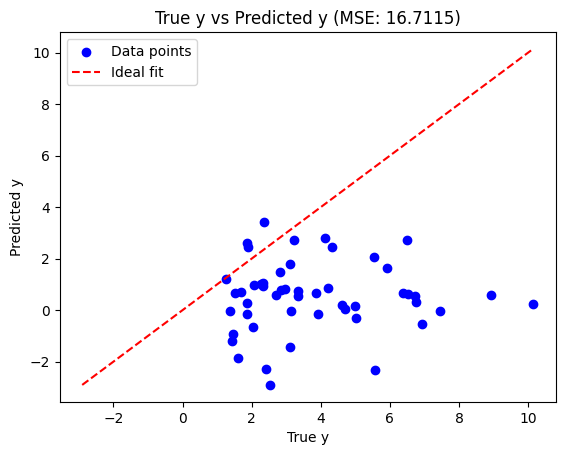

In [23]:
######## VERSION 0.1.2 ########
# 采用了新的 simu 的数据集, 以检验算法的合理性

import torch
from qpth.qp import QPFunction
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. 数据模拟函数
# ------------------------------------------------------------------

def simulate_dataset(n=100, d=2, mode="piecewise", noise_std=0.1, device="cpu"):
    r"""
    根据 mode 生成不同类型的数据 (X, y)。可用于更好地测试算法的有效性。

    参数：
    -------
    n : int
        样本数
    d : int
        特征维度
    mode : str
        - "linear_positive": y 由一个线性组合 + ReLU 组成
        - "piecewise": y 在不同区域有不同的线性关系
        - "reluh_combo": y 是若干 ReLU(x^T w + b) 的组合
    noise_std : float
        高斯噪声标准差
    device : str
        将生成的数据放到此设备上 ("cpu" 或 "cuda")

    返回：
    -------
    X : (n, d) 张量
    y : (n,)   张量
    """
    torch.manual_seed(42)  # 为了可重复性示例，固定一下种子
    X = torch.randn(n, d)
    eps = noise_std * torch.randn(n)  # 噪声

    if mode == "linear_positive":
        # 比如： y = ReLU( 2*x1 + 0.5*x2 + 1 ) + 噪声
        # 仅支持 d >= 2 时更有意义
        w = torch.tensor([2.0, 0.5], dtype=X.dtype)
        b = 1.0
        # 若 d>2，其它维度让它们对 y 的贡献为 0
        if d > 2:
            w = torch.cat([w, torch.zeros(d-2)])
        y = (X @ w) + b
        y = torch.nn.functional.relu(y) + eps

    elif mode == "piecewise":
        # 这里演示一个简单的分段函数：
        # if x[:,0] >= 0: y = 2*x0 + 1
        # else:           y = -3*x0 + 2
        # 这里只用第一个特征 x0 来分段，其它特征只参与噪声
        # d >= 1
        x0 = X[:, 0]
        y = torch.where(x0 >= 0, 2.0*x0 + 1.0, -3.0*x0 + 2.0)
        # 让其它维度对 y 有一点小权重贡献
        if d > 1:
            w_rest = torch.randn(d-1) * 0.5
            y += X[:, 1:] @ w_rest
        # 加噪声
        y = y + eps

    elif mode == "reluh_combo":
        # y = 1 + 2*ReLU(x0) + 3*ReLU(x1) + ...
        # 只演示前两个维度的 ReLU 组合，其它维度若有则仅加小贡献
        y = torch.ones(n)
        if d >= 1:
            y += 2.0*torch.nn.functional.relu(X[:,0])
        if d >= 2:
            y += 3.0*torch.nn.functional.relu(X[:,1])
        if d > 2:
            w_rest = torch.randn(d-2)
            y += X[:, 2:] @ w_rest
        y = y + eps

    else:
        raise ValueError("Unknown mode for simulation.")

    return X.to(device), y.to(device)

# ------------------------------------------------------------------
# 2. 现有 QP 构建和训练流程
# ------------------------------------------------------------------

def build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg):
    """
    构建 Q, p, G, h 矩阵。
    """
    n, d = X.shape
    L = U.shape[0]
    H = S.shape[0]

    total_vars = d + L*n + 2*H*n  # [beta, pi, theta, sigma]

    #--------------------#
    #    1) 构建 Q
    #--------------------#
    Q_diag = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    Q_diag[:d] = lambda_reg  # beta正则
    Q_diag[d + L*n : d + L*n + H*n] = 1.0   # theta部分
    Q_diag[d + L*n + H*n : ] = 1.0          # sigma部分

    Q = torch.diag(Q_diag).unsqueeze(0)

    #--------------------#
    #    2) 构建 p
    #--------------------#
    p = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    p[d + L*n + H*n : ] = tau.repeat(n)
    p = p.unsqueeze(0)

    #--------------------#
    #   3) 构建 G, h
    #--------------------#
    G_rows = 2*L*n + 2*H*n + d
    G = torch.zeros(G_rows, total_vars, dtype=X.dtype, device=X.device)
    h_val = torch.zeros(G_rows, dtype=X.dtype, device=X.device)

    row_idx = 0

    # (a) pi_li >= U[l]*(y[i] - x[i]^T beta) + V[l]
    #     => -pi_li + U[l]*x[i]^T beta <= U[l]*y[i] + V[l]
    for i in range(n):
        for l in range(L):
            G[row_idx, :d] = U[l] * X[i]
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = U[l]*y[i] + V[l]
            row_idx += 1

    # (b) pi_li >= 0 => -pi_li <= 0
    for i in range(n):
        for l in range(L):
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # (c) theta_hi + sigma_hi >= S[h]*(y[i] - x[i]^T beta) + T[h]
    #     => -theta_hi - sigma_hi + S[h]*x[i]^T beta <= S[h]*y[i] + T[h]
    for i in range(n):
        for h_ in range(H):
            G[row_idx, :d] = S[h_] * X[i]
            G[row_idx, d + L*n + h_*n + i] = -1.0   # theta
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0  # sigma
            h_val[row_idx] = S[h_]*y[i] + T[h_]
            row_idx += 1

    # (d) sigma_hi >= 0 => -sigma_hi <= 0
    for i in range(n):
        for h_ in range(H):
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # (e) beta_j >= 0 => -beta_j <= 0
    for j in range(d):
        G[row_idx, j] = -1.0
        h_val[row_idx] = 0.0
        row_idx += 1

    G = G.unsqueeze(0)
    h = h_val.unsqueeze(0)

    #--------------------#
    #   数值稳定修正
    #--------------------#
    eps = 1e-4
    Q = Q + eps * torch.eye(total_vars, dtype=X.dtype, device=X.device).unsqueeze(0)

    return Q, p, G, h

def solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg):
    """
    给定超参数(U, V, S, T, tau)，构建并求解内层QP，返回 beta_opt。
    """
    Q, p, G, h = build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg)
    z = QPFunction(verbose=False)(Q, p, G, h, torch.empty(0, device=X.device), torch.empty(0, device=X.device))
    d = X.shape[1]
    beta_opt = z[:, :d].squeeze(0)
    return beta_opt

def compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg):
    """
    1) 基于给定超参数解内层 QP 得到 beta_opt
    2) 计算外层损失(例如 MSE)，反向传播
    3) 收集对超参数的梯度并返回
    """
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)
    n = X.shape[0]
    y_pred = X @ beta_opt
    # 外层损失: MSE
    loss_outer = (1.0/n) * (y - y_pred).pow(2).sum()

    # 反向传播
    loss_outer.backward()

    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)

    # 梯度清零（避免下一次累加）
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()

    return {
        "beta_opt": beta_opt.detach().clone(),
        "loss": loss_outer.item(),
        "U_grad": U_grad,
        "V_grad": V_grad,
        "S_grad": S_grad,
        "T_grad": T_grad
    }

def train_hyperparams(X, y, U, V, S, T, tau, lambda_reg,
                      lr=1e-2, outer_steps=50):
    """
    多轮外层迭代：在每一步里
      (1) 固定(U, V, S, T)求解内层QP得到 beta_opt
      (2) 计算 outer_loss 并 backward
      (3) 用梯度更新超参数
    返回：更新后的 (U, V, S, T) 以及每一步的损失日志
    """
    loss_history = []

    for step in range(outer_steps):
        # 计算外层损失及梯度
        results = compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg)
        loss_val = results["loss"]
        U_grad, V_grad = results["U_grad"], results["V_grad"]
        S_grad, T_grad = results["S_grad"], results["T_grad"]

        # 梯度下降更新超参数
        with torch.no_grad():
            U -= lr * U_grad
            V -= lr * V_grad
            S -= lr * S_grad
            T -= lr * T_grad

        # 保持 requires_grad=True，以继续反向传播
        U.requires_grad_(True)
        V.requires_grad_(True)
        S.requires_grad_(True)
        T.requires_grad_(True)

        # 记录损失
        loss_history.append(loss_val)

        # 打印日志(可选)
        if (step+1) % 10 == 0:
            print(f"Outer Step [{step+1}/{outer_steps}], Loss={loss_val:.6f}")

    return U, V, S, T, loss_history

# ------------------------------------------------------------------
# 3. 可视化/评估函数
# ------------------------------------------------------------------

def evaluate_and_plot(X, y, U, V, S, T, tau, lambda_reg, title=""):
    """
    (1) 用当前超参数再解一遍内层 QP 拿到 beta_opt
    (2) 计算 MSE 并打印
    (3) 绘制直观对比图：
         - 若 d==1，绘制 X 与 y 以及预测值的散点图
         - 绘制 y 与 y_pred 的散点对比图，并添加45度参考线
    """
    with torch.no_grad():
        beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)
        y_pred = X @ beta_opt
        mse = torch.mean((y - y_pred)**2).item()

    print(f"[{title}] Evaluation MSE: {mse:.6f}")

    # 若特征为1维，则绘制 X 与 y/ŷ 对比图
    d = X.shape[1]
    if d == 1:
        plt.figure()
        x_vals = X.cpu().squeeze().numpy()
        y_true = y.cpu().numpy()
        y_hat = y_pred.cpu().numpy()
        plt.scatter(x_vals, y_true, label="True Y")
        plt.scatter(x_vals, y_hat, label="Pred Y", marker='x')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title(f"{title} (1D feature) MSE: {mse:.4f}")
        plt.legend()
        plt.show()

    # 新增直观对比：绘制 y 与 y_pred 的散点图，并添加45度理想参考线
    plt.figure()
    y_true = y.cpu().numpy()
    y_hat = y_pred.cpu().numpy()
    plt.scatter(y_true, y_hat, c='blue', label='Data points')
    min_val = min(y_true.min(), y_hat.min())
    max_val = max(y_true.max(), y_hat.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal fit')
    plt.xlabel("True y")
    plt.ylabel("Predicted y")
    plt.title(f"True y vs Predicted y (MSE: {mse:.4f})")
    plt.legend()
    plt.show()
# ------------------------------------------------------------------
# 4. 主函数示例
# ------------------------------------------------------------------

def main():
    # 指定设备：GPU 优先，否则 CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # 1) 选择模拟数据集
    #    您可以修改 mode 为 ["linear_positive", "piecewise", "reluh_combo"] 之一
    n, d = 50, 4
    X, y = simulate_dataset(n=n, d=d, mode="piecewise", noise_std=0.1, device=device)
    print("X shape:", X.shape, "y shape:", y.shape)

    # 2) 超参数初始化
    L, H = 2, 2
    lambda_reg = 0.1
    U = torch.randn(L, device=device, requires_grad=True)
    V = torch.randn(L, device=device, requires_grad=True)
    S = torch.randn(H, device=device, requires_grad=True)
    T = torch.randn(H, device=device, requires_grad=True)
    tau = torch.ones(H, device=device, requires_grad=False)

    # 3) 多步外层训练
    outer_steps = 500
    lr = 1e-2
    U_final, V_final, S_final, T_final, loss_history = train_hyperparams(
        X, y, U, V, S, T, tau, lambda_reg,
        lr=lr,
        outer_steps=outer_steps
    )

    # 4) 绘制训练过程的 MSE
    plt.figure()
    plt.plot(loss_history, marker='o')
    plt.xlabel("Outer Iterations")
    plt.ylabel("MSE Loss")
    plt.title("Outer Loss History")
    plt.grid(True)
    plt.show()

    # 5) 在训练结束后，做评估
    evaluate_and_plot(X, y, U_final, V_final, S_final, T_final, tau, lambda_reg, title="Final Model")


if __name__ == "__main__":
    main()


Using device: cuda
Outer Step [10/500], Loss=14.712097
Outer Step [20/500], Loss=14.712097
Outer Step [30/500], Loss=14.712094
Outer Step [40/500], Loss=14.712098
Outer Step [50/500], Loss=14.712097
Outer Step [60/500], Loss=14.712098
Outer Step [70/500], Loss=14.712099
Outer Step [80/500], Loss=14.712097
Outer Step [90/500], Loss=14.712098

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------

Outer Step [100/500], Loss=14.712097
Outer Step [110/500], Loss=14.712098
Outer Step [120/500], Loss=14.712098
Outer Step [130/500], Loss=14.712097
Outer Step [140/500], Loss=1

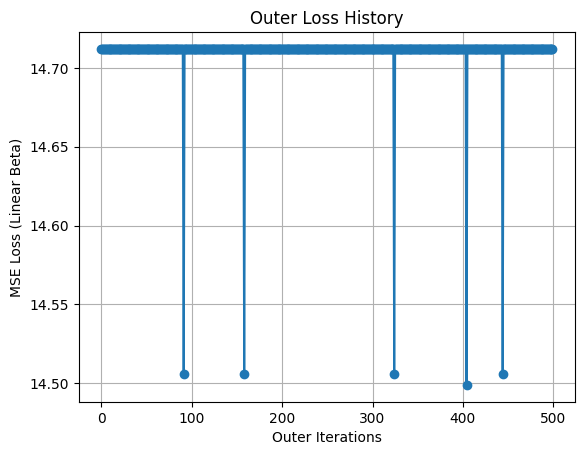

[Final Model] Linear-Predict MSE: 14.712099
[Final Model] Nonlinear-Predict MSE: 3.495857


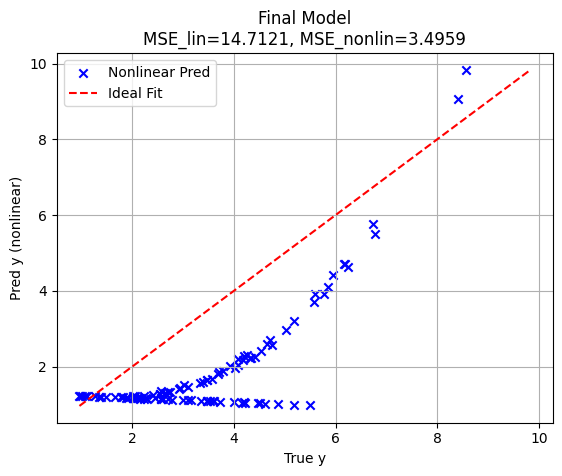

In [25]:
######## VERSION 0.2.0 ########
# 考虑了预测输出时我们是否还是简单的通过 X@beta 进行
# 还是模仿 loss 的定义构造一个更非线性的结构

import torch
from qpth.qp import QPFunction
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1) ReHU 函数定义
# ------------------------------------------------------------------

def rehu(x: torch.Tensor) -> torch.Tensor:
    """
    ReHU 自定义激活: x>0 时输出 x^2/2, 否则输出 0.
    """
    return torch.where(x > 0, 0.5 * x**2, torch.zeros_like(x))


# ------------------------------------------------------------------
# 2) 模型的非线性预测函数
# ------------------------------------------------------------------

def nonlinear_predict(X: torch.Tensor,
                      beta: torch.Tensor,
                      U: torch.Tensor,
                      V: torch.Tensor,
                      S: torch.Tensor,
                      T: torch.Tensor) -> torch.Tensor:
    """
    给定:
      - X: (n, d) 的数据
      - beta: (d,) 学到的线性参数
      - (U, V): L 组超参
      - (S, T): H 组超参
    返回:
      - y_pred: (n,) 的预测值

    这里演示一个简单的“线性 + 激活”组合:
      y_pred[i] = x_i^T beta
                  + sum_{l=1..L} ReLU( U[l]*x_i + V[l] )
                  + sum_{h=1..H} ReHU( S[h]*x_i + T[h] )

    注：若 d>1，而 U[l], S[h] 只是标量，则 U[l]*x_i 是元素乘法，
        需要您在实践中根据意图改成点积或其它形式。
    """
    n, d = X.shape
    # 1) 线性部分
    y_lin = X @ beta  # (n,)

    # 2) ReLU 与 ReHU 部分
    #   如果 d=1，U[l]*X + V[l] 是标量加法 => shape (n,)
    #   对每个样本计算并累计
    y_nonlinear = torch.zeros_like(y_lin)

    for l in range(U.shape[0]):
        # (U[l] * X) => shape(n, d) if d>1; shape(n,) if d=1
        # 这里示例：直接元素乘法 + V[l]
        # 如果 d==1，此时 (U[l]*X).squeeze() 就是 (n,)
        z_l = U[l]*X + V[l]
        # 做一次 squeeze 以便 ReLU 正确处理 (n,) 形状
        z_l = z_l.squeeze(-1) if d==1 else z_l.sum(dim=1)
        # sum(dim=1) 表示若 d>1，可以把 (n,d) => (n,), 视为 dot(U[l], x_i) + V[l]
        y_nonlinear += torch.relu(z_l)

    for h in range(S.shape[0]):
        z_h = S[h]*X + T[h]
        z_h = z_h.squeeze(-1) if d==1 else z_h.sum(dim=1)
        y_nonlinear += rehu(z_h)

    return y_lin + y_nonlinear


# ------------------------------------------------------------------
# 3) 现有 QP 构建和训练流程 (与之前相同)
# ------------------------------------------------------------------

def build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg):
    n, d = X.shape
    L = U.shape[0]
    H = S.shape[0]

    total_vars = d + L*n + 2*H*n  # [beta, pi, theta, sigma]

    # 1) Q
    Q_diag = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    Q_diag[:d] = lambda_reg  # beta正则
    Q_diag[d + L*n : d + L*n + H*n] = 1.0   # theta部分
    Q_diag[d + L*n + H*n : ] = 1.0          # sigma部分
    Q = torch.diag(Q_diag).unsqueeze(0)

    # 2) p
    p = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    p[d + L*n + H*n : ] = tau.repeat(n)
    p = p.unsqueeze(0)

    # 3) G, h
    G_rows = 2*L*n + 2*H*n + d
    G = torch.zeros(G_rows, total_vars, dtype=X.dtype, device=X.device)
    h_val = torch.zeros(G_rows, dtype=X.dtype, device=X.device)

    row_idx = 0

    # pi_li >= U[l]*(y[i] - x[i]^T beta) + V[l]
    for i in range(n):
        for l in range(L):
            G[row_idx, :d] = U[l] * X[i]
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = U[l]*y[i] + V[l]
            row_idx += 1

    # pi_li >= 0
    for i in range(n):
        for l in range(L):
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # theta_hi + sigma_hi >= S[h]*(y[i] - x[i]^T beta) + T[h]
    for i in range(n):
        for h_ in range(H):
            G[row_idx, :d] = S[h_] * X[i]
            G[row_idx, d + L*n + h_*n + i] = -1.0   # theta
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0  # sigma
            h_val[row_idx] = S[h_]*y[i] + T[h_]
            row_idx += 1

    # sigma_hi >= 0
    for i in range(n):
        for h_ in range(H):
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # beta_j >= 0
    for j in range(d):
        G[row_idx, j] = -1.0
        h_val[row_idx] = 0.0
        row_idx += 1

    G = G.unsqueeze(0)
    h = h_val.unsqueeze(0)

    # 数值稳定修正
    eps = 1e-4
    Q = Q + eps * torch.eye(total_vars, dtype=X.dtype, device=X.device).unsqueeze(0)

    return Q, p, G, h

def solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg):
    Q, p, G, h = build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg)
    z = QPFunction(verbose=False)(Q, p, G, h, torch.empty(0, device=X.device), torch.empty(0, device=X.device))
    d = X.shape[1]
    beta_opt = z[:, :d].squeeze(0)
    return beta_opt

def compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg):
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)
    n = X.shape[0]
    # 外层损失: MSE of (y - X@beta)
    #   (若外层损失仅如此，则训练时并没有直接把“非线性预测”纳入外层loss，
    #    而是对线性部分进行拟合 + ReLU/ReHU 相关的Q约束。)
    y_pred = X @ beta_opt
    loss_outer = (1.0 / n) * (y - y_pred).pow(2).sum()

    loss_outer.backward()

    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)

    # 梯度清零
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()

    return {
        "beta_opt": beta_opt.detach().clone(),
        "loss": loss_outer.item(),
        "U_grad": U_grad,
        "V_grad": V_grad,
        "S_grad": S_grad,
        "T_grad": T_grad
    }

def train_hyperparams(X, y, U, V, S, T, tau, lambda_reg,
                      lr=1e-2, outer_steps=50):
    loss_history = []
    for step in range(outer_steps):
        results = compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg)
        loss_val = results["loss"]
        U_grad, V_grad = results["U_grad"], results["V_grad"]
        S_grad, T_grad = results["S_grad"], results["T_grad"]

        with torch.no_grad():
            U -= lr * U_grad
            V -= lr * V_grad
            S -= lr * S_grad
            T -= lr * T_grad

        U.requires_grad_(True)
        V.requires_grad_(True)
        S.requires_grad_(True)
        T.requires_grad_(True)

        loss_history.append(loss_val)

        if (step+1) % 10 == 0:
            print(f"Outer Step [{step+1}/{outer_steps}], Loss={loss_val:.6f}")

    return U, V, S, T, loss_history

# ------------------------------------------------------------------
# 4) 评估与可视化
# ------------------------------------------------------------------

def evaluate_and_plot(X, y, U, V, S, T, tau, lambda_reg, title=""):
    """
    (1) 用当前超参数解内层 QP 拿到 beta_opt
    (2) 分别用 "线性预测" 和 "非线性预测" 做评估
    (3) 绘制对比图
    """
    with torch.no_grad():
        beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)

        # 线性预测
        y_pred_linear = X @ beta_opt
        mse_linear = torch.mean((y - y_pred_linear)**2).item()

        # 非线性预测
        y_pred_nonlinear = nonlinear_predict(X, beta_opt, U, V, S, T)
        mse_nonlinear = torch.mean((y - y_pred_nonlinear)**2).item()

    print(f"[{title}] Linear-Predict MSE: {mse_linear:.6f}")
    print(f"[{title}] Nonlinear-Predict MSE: {mse_nonlinear:.6f}")

    # 对比散点：真实值 vs. 预测值（非线性预测）
    y_true = y.cpu().numpy()
    y_hat_nl = y_pred_nonlinear.cpu().numpy()

    plt.figure()
    plt.scatter(y_true, y_hat_nl, label="Nonlinear Pred", marker='x', c='blue')

    # 画一下理想对角线
    min_val = min(y_true.min(), y_hat_nl.min())
    max_val = max(y_true.max(), y_hat_nl.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')

    plt.xlabel("True y")
    plt.ylabel("Pred y (nonlinear)")
    plt.title(f"{title}\nMSE_lin={mse_linear:.4f}, MSE_nonlin={mse_nonlinear:.4f}")
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------------------------------------------------
# 5) 主入口：生成示例数据并进行训练
# ------------------------------------------------------------------

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # -- 生成数据(可根据需求改动 n, d, 以及数据分布) --
    n, d = 100, 1
    torch.manual_seed(42)
    X = torch.randn(n, d).to(device)
    # 让 y 在一边是正，另一边是负，以便可能出现分段
    y = torch.where(X.squeeze() > 0, 2.0*X.squeeze() + 1.0, -3.0*X.squeeze() + 2.0)
    y += 0.1 * torch.randn_like(y)  # 加一点噪声

    # reshape y -> (n,)
    y = y.view(-1).to(device)

    # -- 超参数初始化 --
    L, H = 2, 2
    lambda_reg = 0.1

    U = torch.randn(L, device=device, requires_grad=True)
    V = torch.randn(L, device=device, requires_grad=True)
    S = torch.randn(H, device=device, requires_grad=True)
    T = torch.randn(H, device=device, requires_grad=True)
    tau = torch.ones(H, device=device, requires_grad=False)

    # -- 外层优化 --
    outer_steps = 500
    lr = 1e-2
    U_final, V_final, S_final, T_final, loss_history = train_hyperparams(
        X, y, U, V, S, T, tau, lambda_reg,
        lr=lr,
        outer_steps=outer_steps
    )

    # -- 画一下训练过程的线性损失收敛 --
    plt.figure()
    plt.plot(loss_history, marker='o')
    plt.xlabel("Outer Iterations")
    plt.ylabel("MSE Loss (Linear Beta)")
    plt.title("Outer Loss History")
    plt.grid(True)
    plt.show()

    # -- 评估：分别看纯线性预测 & 非线性预测的 MSE --
    evaluate_and_plot(X, y, U_final, V_final, S_final, T_final, tau, lambda_reg, title="Final Model")

if __name__ == "__main__":
    main()


Using device: cuda

--- Generating laplace noise data ---

--- Training on laplace noise data ---
[outer step 10/500] MSE loss = 2.429858
[outer step 20/500] MSE loss = 2.429511
[outer step 30/500] MSE loss = 2.429173
[outer step 40/500] MSE loss = 2.428845
[outer step 50/500] MSE loss = 2.428523
[outer step 60/500] MSE loss = 2.428206
[outer step 70/500] MSE loss = 2.427895
[outer step 80/500] MSE loss = 2.427598
[outer step 90/500] MSE loss = 2.427295
[outer step 100/500] MSE loss = 2.427013
[outer step 110/500] MSE loss = 2.426712
[outer step 120/500] MSE loss = 2.426418
[outer step 130/500] MSE loss = 2.426204
[outer step 140/500] MSE loss = 2.425849

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of 

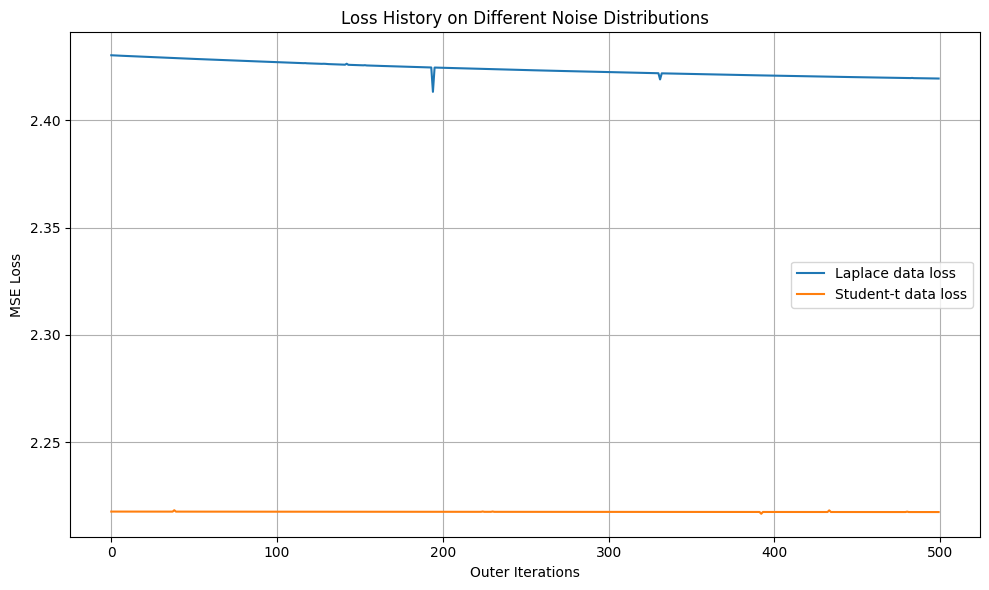


--- Comparing beta estimation across noise types ---
Laplace mean absolute beta error: 0.119326
Student-t mean absolute beta error: 0.063215


In [14]:
######## VERSION 0.3.0 ########
# 更改思路,这次的数据是Y = Xbeta+eps,eps 是一些其他分布的噪声
import torch
from qpth.qp import QPFunction
import matplotlib.pyplot as plt

############################
#  1) 数据模拟函数
############################
def simulate_data(n, d, noise_type="laplace", scale=1.0, df=3.0, device="cpu", seed=42):
    r"""
    生成 X, y, 以及真实beta_true, 其中:
      - X ~ N(0, 1)  (n x d)
      - beta_true ~ Uniform(0,1)  (d 维)
      - y = X beta_true + eps
      - eps 为噪声, 根据 noise_type 取 Laplace(0, scale) 或 StudentT(df)*scale

    参数:
        n (int): 样本数
        d (int): 特征维度
        noise_type (str): "laplace" 或 "student"
        scale (float): 噪声尺度
        df (float): Student-t 的自由度 (若 noise_type=="student" 时有用)
        device (str): 放置数据的设备, "cpu" 或 "cuda"
        seed (int): 随机种子, 便于复现
    返回:
        X, y, beta_true
    """
    torch.manual_seed(seed)

    # 生成真实beta_true
    beta_true = torch.rand(d)*10  # Uniform(0,1)
    
    # 生成 X
    X = torch.randn(n, d)
    
    # 生成噪声 eps
    if noise_type.lower() == "laplace":
        # Laplace(0, 1) => 再乘以scale
        # PyTorch目前没有内置的laplace随机数(老版本Torch), 可用对数或自己实现
        # 新版(>=1.10)有 torch.distributions.Laplace，示例如下:
        dist = torch.distributions.Laplace(loc=0.0, scale=scale)
        eps = dist.sample((n,))
    elif noise_type.lower() == "student":
        # StudentT(df) => 再乘以 scale
        dist = torch.distributions.StudentT(df=df)
        eps = dist.sample((n,)) * scale
    else:
        raise ValueError(f"noise_type仅支持 'laplace' 或 'student', 但收到 {noise_type}")

    # 构造 y
    y = X.matmul(beta_true) + eps
    
    # 转到指定 device
    X = X.to(device)
    y = y.to(device)
    beta_true = beta_true.to(device)

    return X, y, beta_true

############################
#  2) QP 与外层训练代码(与之前相同)
############################
def build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg):
    n, d = X.shape
    L = U.shape[0]
    H = S.shape[0]
    
    total_vars = d + L*n + 2*H*n  # [beta, pi, theta, sigma]
    
    Q_diag = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    Q_diag[:d] = lambda_reg
    Q_diag[d + L*n : d + L*n + H*n] = 1.0
    Q_diag[d + L*n + H*n : ] = 1.0
    
    Q = torch.diag(Q_diag).unsqueeze(0)
    
    p = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    p[d + L*n + H*n : ] = tau.repeat(n)
    p = p.unsqueeze(0)
    
    G_rows = 2*L*n + 2*H*n + d
    G = torch.zeros(G_rows, total_vars, dtype=X.dtype, device=X.device)
    h_val = torch.zeros(G_rows, dtype=X.dtype, device=X.device)
    
    row_idx = 0
    
    # pi_li >= U[l]*(y[i] - x[i]^T beta) + V[l]
    for i in range(n):
        for l in range(L):
            G[row_idx, :d] = U[l] * X[i]
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = U[l]*y[i] + V[l]
            row_idx += 1
    
    # pi_li >= 0
    for i in range(n):
        for l in range(L):
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # theta_hi + sigma_hi >= S[h]*(y[i] - x[i]^T beta) + T[h]
    for i in range(n):
        for h_ in range(H):
            G[row_idx, :d] = S[h_] * X[i]
            G[row_idx, d + L*n + h_*n + i] = -1.0
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = S[h_]*y[i] + T[h_]
            row_idx += 1

    # sigma_hi >= 0
    for i in range(n):
        for h_ in range(H):
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # beta_j >= 0
    for j in range(d):
        G[row_idx, j] = -1.0
        h_val[row_idx] = 0.0
        row_idx += 1
    
    G = G.unsqueeze(0)
    h = h_val.unsqueeze(0)
    
    eps = 1e-4
    Q = Q + eps * torch.eye(total_vars, dtype=X.dtype, device=X.device).unsqueeze(0)
    
    return Q, p, G, h

def solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg):
    Q, p, G, h = build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg)
    z = QPFunction(verbose=False)(Q, p, G, h, torch.empty(0, device=X.device), torch.empty(0, device=X.device))
    d = X.shape[1]
    beta_opt = z[:, :d].squeeze(0)
    return beta_opt

def compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg):
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)
    n = X.shape[0]
    y_pred = X @ beta_opt
    loss_outer = (1.0/n) * (y - y_pred).pow(2).sum()
    
    loss_outer.backward()
    
    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)
    
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()
    
    return {
        "beta_opt": beta_opt.detach().clone(),
        "loss": loss_outer.item(),
        "U_grad": U_grad,
        "V_grad": V_grad,
        "S_grad": S_grad,
        "T_grad": T_grad
    }

def train_hyperparams(X, y, U, V, S, T, tau, lambda_reg,
                      lr=1e-2, outer_steps=50):
    loss_history = []
    
    for step in range(outer_steps):
        results = compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg)
        loss_val = results["loss"]
        U_grad, V_grad = results["U_grad"], results["V_grad"]
        S_grad, T_grad = results["S_grad"], results["T_grad"]
        
        with torch.no_grad():
            U -= lr * U_grad
            V -= lr * V_grad
            S -= lr * S_grad
            T -= lr * T_grad

        U.requires_grad_(True)
        V.requires_grad_(True)
        S.requires_grad_(True)
        T.requires_grad_(True)
        
        loss_history.append(loss_val)
        
        if (step+1) % 10 == 0:
            print(f"[outer step {step+1}/{outer_steps}] MSE loss = {loss_val:.6f}")
    
    return U, V, S, T, loss_history

############################
#  3) 评估与演示
############################
def evaluate_and_print(X, y, beta_opt, beta_true):
    """
    给定最终求得的 beta_opt，对 (X,y) 做预测并和 y 比较。
    打印 MSE、MAE等，同时和 beta_true 做对比。
    """
    with torch.no_grad():
        y_pred = X.matmul(beta_opt)
        mse = ((y_pred - y)**2).mean().item()
        mae = (y_pred - y).abs().mean().item()
        print(f"Final MSE: {mse:.6f}")
        print(f"Final MAE: {mae:.6f}")

        if beta_true is not None:
            # 仅仅看一下beta误差
            print("True beta:", beta_true)
            print("Optimal beta:", beta_opt)
            print("Difference:", beta_opt - beta_true)
            beta_mse = ((beta_opt - beta_true)**2).mean().item()
            beta_mae = (beta_opt - beta_true).abs().mean().item()
            print(f"beta_opt vs beta_true - MSE: {beta_mse:.6f}, MAE: {beta_mae:.6f}")

def experiment_with_noise(noise_type, n=200, d=3, L=2, H=2, scale=1.0, df=3.0, 
                         lambda_reg=0.1, lr=0.01, outer_steps=100, seed=None):
    """
    针对指定噪声类型运行完整实验
    
    参数:
        noise_type (str): 噪声类型 ("laplace" 或 "student")
        n, d, L, H: 数据维度和模型参数
        scale: 噪声尺度
        df: Student-t分布自由度
        lambda_reg: 正则化系数
        lr: 学习率
        outer_steps: 外循环迭代次数
        seed: 随机种子
    
    返回:
        dict: 包含实验结果的字典
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 设置默认种子
    if seed is None:
        seed = 42 if noise_type == "laplace" else 123
    
    # 生成数据
    print(f"\n--- Generating {noise_type} noise data ---")
    X, y, beta_true = simulate_data(
        n=n, d=d, noise_type=noise_type, scale=scale, 
        df=df if noise_type == "student" else None, 
        device=device, seed=seed
    )
    
    # 初始化超参数
    U = torch.randn(L, device=device, requires_grad=True)
    V = torch.randn(L, device=device, requires_grad=True)
    S = torch.randn(H, device=device, requires_grad=True)
    T = torch.randn(H, device=device, requires_grad=True)
    tau = torch.ones(H, device=device, requires_grad=False)
    
    # 训练模型
    print(f"\n--- Training on {noise_type} noise data ---")
    U_final, V_final, S_final, T_final, loss_history = train_hyperparams(
        X, y, U, V, S, T, tau, lambda_reg=lambda_reg,
        lr=lr, outer_steps=outer_steps
    )
    
    # 评估模型
    beta_opt = solve_inner_qpth(U_final, V_final, S_final, T_final, tau, X, y, lambda_reg)
    print(f"\n--- Evaluation on {noise_type} noise data ---")
    evaluate_and_print(X, y, beta_opt, beta_true)
    
    
    # 返回实验结果
    return {
        "X": X, "y": y, "beta_true": beta_true,
        "beta_opt": beta_opt, 
        "hyperparams": {"U": U_final, "V": V_final, "S": S_final, "T": T_final},
        "loss_history": loss_history
    }

def plot_loss_comparison(results_dict, title="Loss History Comparison"):
    """
    绘制不同噪声分布的损失曲线对比
    
    参数:
        results_dict (dict): 包含不同实验损失历史的字典
        title (str): 图表标题
    """
    plt.figure(figsize=(10, 6))
    
    for name, result in results_dict.items():
        plt.plot(result["loss_history"], label=f"{name} data loss")
    
    plt.xlabel("Outer Iterations")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # 运行 Laplace 噪声实验
    laplace_results = experiment_with_noise(
        noise_type="laplace", 
        lr=1e-2, 
        outer_steps=500
    )
    
    # 运行 Student-t 噪声实验
    student_t_results = experiment_with_noise(
        noise_type="student", 
        lr=1e-2, 
        outer_steps=500
    )
    
    # 绘制损失曲线对比
    plot_loss_comparison({
        "Laplace": laplace_results,
        "Student-t": student_t_results
    }, title="Loss History on Different Noise Distributions")
    
    # 额外分析 (可选)
    # 比较不同噪声类型下的 beta 估计效果
    print("\n--- Comparing beta estimation across noise types ---")
    lap_rel_error = (laplace_results["beta_opt"] - laplace_results["beta_true"]).abs().mean()
    st_rel_error = (student_t_results["beta_opt"] - student_t_results["beta_true"]).abs().mean()
    print(f"Laplace mean absolute beta error: {lap_rel_error:.6f}")
    print(f"Student-t mean absolute beta error: {st_rel_error:.6f}")

if __name__ == "__main__":
    main()



Using device: cuda

--- Generating laplace noise data ---

--- Training Autoloss on laplace noise data ---
[outer step 10/200] MSE loss = 2.429858
[outer step 20/200] MSE loss = 2.429511
[outer step 30/200] MSE loss = 2.429173
[outer step 40/200] MSE loss = 2.428845
[outer step 50/200] MSE loss = 2.428523
[outer step 60/200] MSE loss = 2.428206
[outer step 70/200] MSE loss = 2.427895
[outer step 80/200] MSE loss = 2.427598
[outer step 90/200] MSE loss = 2.427295
[outer step 100/200] MSE loss = 2.427013
[outer step 110/200] MSE loss = 2.426712
[outer step 120/200] MSE loss = 2.426418
[outer step 130/200] MSE loss = 2.426204
[outer step 140/200] MSE loss = 2.425849

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the n

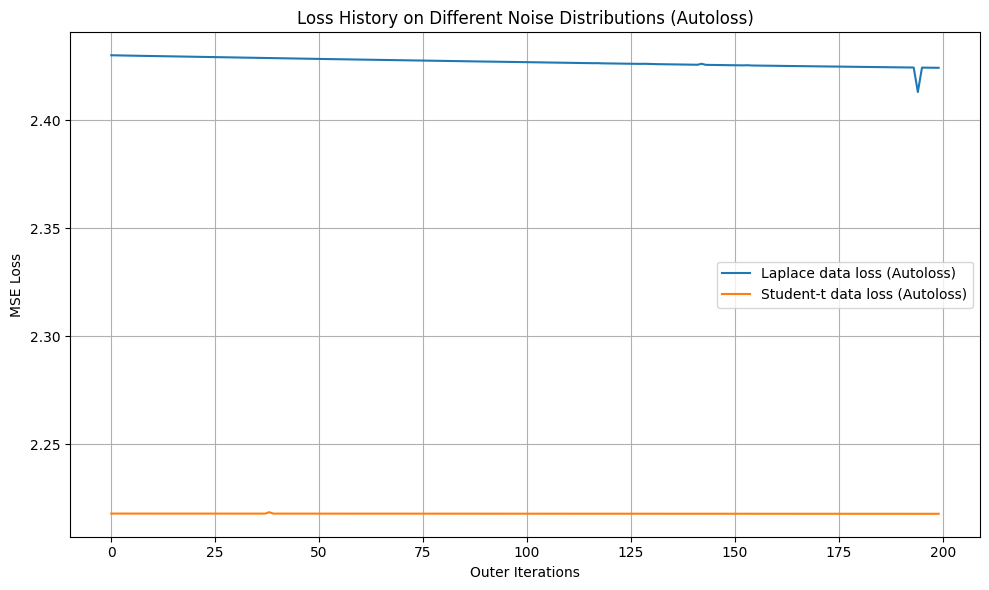


--- Comparing final Beta across noise types ---
Laplace: mean |beta_autoloss - beta_ols| = 0.054652
Student-t: mean |beta_autoloss - beta_ols| = 0.017338
Laplace True beta AutoLoss: tensor([8.7588, 9.1074, 3.5612], device='cuda:0', grad_fn=<SqueezeBackward1>)
Laplace True beta OLS: tensor([8.7654, 9.0593, 3.6704], device='cuda:0')
Student-t True beta AutoLoss: tensor([2.9995, 5.1950, 2.3926], device='cuda:0', grad_fn=<SqueezeBackward1>)
Student-t True beta OLS: tensor([2.9772, 5.1906, 2.4179], device='cuda:0')


In [ ]:
######## VERSION 0.4.0 ########
# 在现有代码基础上，引入 OLS 对比模块

import torch
from qpth.qp import QPFunction
import matplotlib.pyplot as plt

############################
#  1) 数据模拟函数
############################
def simulate_data(n, d, noise_type="laplace", scale=1.0, df=3.0, device="cpu", seed=42):
    r"""
    生成 X, y, 以及真实beta_true, 其中:
      - X ~ N(0, 1)  (n x d)
      - beta_true ~ Uniform(0,1)*10  (d 维, 放大10倍使系数更明显)
      - y = X beta_true + eps
      - eps 根据 noise_type 取 Laplace(0, scale) 或 StudentT(df)*scale

    参数:
        n (int): 样本数
        d (int): 特征维度
        noise_type (str): "laplace" 或 "student"
        scale (float): 噪声尺度
        df (float): Student-t 的自由度 (若 noise_type=="student" 时有用)
        device (str): 放置数据的设备, "cpu" 或 "cuda"
        seed (int): 随机种子, 便于复现
    返回:
        X, y, beta_true
    """
    torch.manual_seed(seed)

    beta_true = torch.rand(d)*10  # Uniform(0,1) 然后乘10
    X = torch.randn(n, d)
    
    if noise_type.lower() == "laplace":
        # Laplace(0, scale)
        dist = torch.distributions.Laplace(loc=0.0, scale=scale)
        eps = dist.sample((n,))
    elif noise_type.lower() == "student":
        # StudentT(df) => 再乘以 scale
        dist = torch.distributions.StudentT(df=df)
        eps = dist.sample((n,)) * scale
    else:
        raise ValueError(f"noise_type仅支持 'laplace' 或 'student', 但收到 {noise_type}")

    y = X.matmul(beta_true) + eps
    
    # 转到指定 device
    X = X.to(device)
    y = y.to(device)
    beta_true = beta_true.to(device)

    return X, y, beta_true

############################
#  2) 构建内层 QP 的函数
############################
def build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg):
    n, d = X.shape
    L = U.shape[0]
    H = S.shape[0]
    
    total_vars = d + L*n + 2*H*n  # [beta, pi, theta, sigma]
    
    Q_diag = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    Q_diag[:d] = lambda_reg
    Q_diag[d + L*n : d + L*n + H*n] = 1.0
    Q_diag[d + L*n + H*n : ] = 1.0
    
    Q = torch.diag(Q_diag).unsqueeze(0)
    
    p = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    # sigma 部分的线性项
    p[d + L*n + H*n : ] = tau.repeat(n)
    p = p.unsqueeze(0)
    
    G_rows = 2*L*n + 2*H*n + d
    G = torch.zeros(G_rows, total_vars, dtype=X.dtype, device=X.device)
    h_val = torch.zeros(G_rows, dtype=X.dtype, device=X.device)
    
    row_idx = 0
    
    # pi_li >= U[l]*(y[i] - x[i]^T beta) + V[l]
    for i in range(n):
        for l in range(L):
            G[row_idx, :d] = U[l] * X[i]
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = U[l]*y[i] + V[l]
            row_idx += 1
    
    # pi_li >= 0
    for i in range(n):
        for l in range(L):
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # theta_hi + sigma_hi >= S[h]*(y[i] - x[i]^T beta) + T[h]
    for i in range(n):
        for h_ in range(H):
            G[row_idx, :d] = S[h_] * X[i]
            G[row_idx, d + L*n + h_*n + i] = -1.0
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = S[h_]*y[i] + T[h_]
            row_idx += 1

    # sigma_hi >= 0
    for i in range(n):
        for h_ in range(H):
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # beta_j >= 0
    for j in range(d):
        G[row_idx, j] = -1.0
        h_val[row_idx] = 0.0
        row_idx += 1
    
    G = G.unsqueeze(0)
    h = h_val.unsqueeze(0)
    
    eps = 1e-4
    Q = Q + eps * torch.eye(total_vars, dtype=X.dtype, device=X.device).unsqueeze(0)
    
    return Q, p, G, h

############################
#  2) 内层QP求解 & 外层梯度
############################
def solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg):
    Q, p, G, h = build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg)
    z = QPFunction(verbose=False)(Q, p, G, h, torch.empty(0, device=X.device), torch.empty(0, device=X.device))
    d = X.shape[1]
    beta_opt = z[:, :d].squeeze(0)
    return beta_opt

def compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg):
    """
    固定U, V, S, T，求解内层QP获得beta_opt, 
    然后对外层MSE损失(对beta_opt的函数)进行反向传播, 
    得到对U, V, S, T的梯度.
    """
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)
    n = X.shape[0]
    y_pred = X @ beta_opt
    loss_outer = (1.0/n) * (y - y_pred).pow(2).sum()
    
    loss_outer.backward()
    
    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)
    
    # 清零, 以免多次累加
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()
    
    return {
        "beta_opt": beta_opt.detach().clone(),
        "loss": loss_outer.item(),
        "U_grad": U_grad,
        "V_grad": V_grad,
        "S_grad": S_grad,
        "T_grad": T_grad
    }

############################
#  2) 外层训练循环
############################
def train_hyperparams(X, y, U, V, S, T, tau, lambda_reg,
                      lr=1e-2, outer_steps=50):
    """
    多轮外层训练: 通过手动梯度下降更新 U, V, S, T
    """
    loss_history = []
    
    for step in range(outer_steps):
        results = compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg)
        loss_val = results["loss"]
        U_grad, V_grad = results["U_grad"], results["V_grad"]
        S_grad, T_grad = results["S_grad"], results["T_grad"]
        
        with torch.no_grad():
            U -= lr * U_grad
            V -= lr * V_grad
            S -= lr * S_grad
            T -= lr * T_grad

        U.requires_grad_(True)
        V.requires_grad_(True)
        S.requires_grad_(True)
        T.requires_grad_(True)
        
        loss_history.append(loss_val)
        
        if (step+1) % 10 == 0:
            print(f"[outer step {step+1}/{outer_steps}] MSE loss = {loss_val:.6f}")
    
    return U, V, S, T, loss_history

############################
#  3) OLS 解(可加Ridge)
############################
def solve_ols(X, y, lambda_reg=0.0):
    r"""
    计算最简单的(可能带L2正则) OLS 闭式解:
      beta_ols = (X^T X + lambda_reg * I)^(-1) X^T y
    其中不考虑非负约束, 仅供对比.
    """
    n, d = X.shape
    A = X.t() @ X
    regI = lambda_reg * torch.eye(d, dtype=X.dtype, device=X.device)
    A = A + regI
    b = X.t() @ y
    
    # 如果 A 不可逆(奇异), 需要赝逆. 这里直接尝试 solve, 
    # 若 PyTorch 版本够新可用 torch.linalg.solve() 
    # 老版可 fallback 到 torch.inverse(A)@b
    beta_ols = torch.linalg.solve(A, b)
    return beta_ols

############################
#  4) 评估与演示
############################
def evaluate_and_print(X, y, beta_est, beta_true, label=""):
    """
    给定最终求得的 beta_est，对 (X,y) 做预测并和 y 比较。
    label: 打印前缀(如 "Autoloss" / "OLS")
    """
    with torch.no_grad():
        y_pred = X.matmul(beta_est)
        mse = ((y_pred - y)**2).mean().item()
        mae = (y_pred - y).abs().mean().item()
        print(f"{label} MSE: {mse:.6f}")
        print(f"{label} MAE: {mae:.6f}")

        if beta_true is not None:
            beta_mse = ((beta_est - beta_true)**2).mean().item()
            beta_mae = (beta_est - beta_true).abs().mean().item()
            print(f"{label} Beta MSE: {beta_mse:.6f}, Beta MAE: {beta_mae:.6f}")
            # 可选：打印Beta向量对比
            # print(f"{label} Beta diff = {beta_est - beta_true}")

def experiment_with_noise(noise_type, n=200, d=3, L=2, H=2, scale=1.0, df=3.0, 
                         lambda_reg=0.1, lr=0.01, outer_steps=100, seed=None):
    """
    针对指定噪声类型运行完整实验: 既跑Autoloss, 也跑OLS做对比
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if seed is None:
        seed = 42 if noise_type == "laplace" else 123
    
    print(f"\n--- Generating {noise_type} noise data ---")
    X, y, beta_true = simulate_data(
        n=n, d=d, noise_type=noise_type, scale=scale, 
        df=df if noise_type == "student" else None, 
        device=device, seed=seed
    )
    
    # 初始化超参数
    U = torch.randn(L, device=device, requires_grad=True)
    V = torch.randn(L, device=device, requires_grad=True)
    S = torch.randn(H, device=device, requires_grad=True)
    T = torch.randn(H, device=device, requires_grad=True)
    tau = torch.ones(H, device=device, requires_grad=False)
    
    # 1) 训练 Autoloss
    print(f"\n--- Training Autoloss on {noise_type} noise data ---")
    U_final, V_final, S_final, T_final, loss_history = train_hyperparams(
        X, y, U, V, S, T, tau, lambda_reg=lambda_reg,
        lr=lr, outer_steps=outer_steps
    )
    
    beta_autoloss = solve_inner_qpth(U_final, V_final, S_final, T_final, tau, X, y, lambda_reg)
    
    print(f"\n--- Evaluate Autoloss on {noise_type} noise data ---")
    evaluate_and_print(X, y, beta_autoloss, beta_true, label="Autoloss")
    
    # 2) 对比 OLS
    print(f"\n--- Solve OLS on {noise_type} noise data ---")
    beta_ols = solve_ols(X, y, lambda_reg=lambda_reg)
    
    print(f"--- Evaluate OLS on {noise_type} noise data ---")
    evaluate_and_print(X, y, beta_ols, beta_true, label="OLS")
    
    # 返回实验结果
    return {
        "X": X, 
        "y": y, 
        "beta_true": beta_true,
        "beta_autoloss": beta_autoloss,
        "beta_ols": beta_ols,
        "hyperparams": {"U": U_final, "V": V_final, "S": S_final, "T": T_final},
        "loss_history": loss_history
    }

def plot_loss_comparison(results_dict, title="Loss History Comparison"):
    """
    绘制不同噪声分布的损失曲线对比
    """
    plt.figure(figsize=(10, 6))
    
    for name, result in results_dict.items():
        plt.plot(result["loss_history"], label=f"{name} data loss (Autoloss)")
    
    plt.xlabel("Outer Iterations")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def reHU_piecewise(x, gamma):
    r"""
    实现分段函数 ReHU_gamma(x):
       = 0,                                       if x <= 0
       = 0.5 * x^2,                               if 0 < x < gamma
       = (x^2)/4 + (gamma*x)/2 - (gamma^2)/4,      if x >= gamma

    x, gamma 可以是标量或等长张量，通过 torch.where 分段拼接。
    """
    cond0 = (x <= 0)
    cond2 = (x >= gamma)
    
    val0 = torch.zeros_like(x)                           # x <= 0
    val1 = 0.5 * x**2                                    # 0 < x < gamma
    val2 = (x**2)/4 + 0.5 * gamma * x - (gamma**2)/4      # x >= gamma
    
    out = torch.where(cond0, val0, val1)
    out = torch.where(cond2, val2, out)
    return out

def sample_autoloss(r, U, V, S, T, gamma):
    r"""
    对“单个”残差 r 计算:
      loss(r) = sum_l ReLU(u_l*r + v_l)  +  sum_h ReHU_gamma_h(s_h*r + t_h).
    其中:
      U, V: shape = [L]
      S, T, gamma: shape = [H]
    r 可以是标量，也可以是长度为 N 的 1D Tensor(向量化批量处理)。
    返回对应的 loss(r) 张量，形状与 r 一致。
    """
    if not isinstance(r, torch.Tensor):
        r = torch.tensor(r, dtype=U.dtype, device=U.device)
    if r.dim() == 0:
        r = r.view(1)  # 保证 shape [N], 至少 batch=1

    # 第1部分: sum_l ReLU(u_l*r + v_l)
    # => 先让 r=>[1,N], U,V =>[L], broadcast => shape [L,N] -> ReLU -> sum over l -> [N]
    r_vals = r.unsqueeze(0)                # shape [1,N]
    uv = U.unsqueeze(1)*r_vals + V.unsqueeze(1)  # [L,N]
    partL = torch.relu(uv).sum(dim=0)            # [N]

    # 第2部分: sum_h ReHU_gamma_h(s_h*r + t_h)
    # => 同理, shape [H,N], sum over h => [N]
    st = S.unsqueeze(1)*r_vals + T.unsqueeze(1)       # [H,N]
    gamma_b = gamma.unsqueeze(1).expand_as(st)        # [H,N]
    partH = reHU_piecewise(st, gamma_b).sum(dim=0)    # [N]
    
    return partL + partH

def compute_dataset_autoloss(X, y, beta, U, V, S, T, gamma):
    r"""
    对整个数据集 (X,y) 逐样本计算残差 r_i = y_i - x_i^T beta，
    再用学到的 (U,V,S,T,gamma) 计算每个样本的 loss_i = autoloss(r_i)。
    
    返回:
       residuals: [n] 张量, 其中 residuals[i] = r_i
       losses:    [n] 张量, 其中 losses[i] = loss_i
       total_loss: 标量, 全部样本的总和
    """
    with torch.no_grad():
        residuals = y - X.mv(beta)  # shape [n]
        # 对每个样本 i 的 r_i, 计算 autoloss(r_i)
        losses = sample_autoloss(residuals, U, V, S, T, gamma)
        total_loss = losses.sum().item()
    return residuals, losses, total_loss

def plot_dataset_autoloss(X, y, beta, U, V, S, T, gamma, sort_by_residual=True):
    r"""
    计算并绘制 (residual, loss) 对。
      - 若 sort_by_residual=True, 按 r_i 升序排序后用折线或散点连起来，形成一条分段式曲线。
      - 否则直接按数据索引的顺序画散点。
    """
    residuals, losses, total_loss = compute_dataset_autoloss(X, y, beta, U, V, S, T, gamma)
    
    # 排序(可选)
    if sort_by_residual:
        idx_sorted = torch.argsort(residuals)
        r_plot = residuals[idx_sorted]
        loss_plot = losses[idx_sorted]
    else:
        r_plot = residuals
        loss_plot = losses
    
    plt.figure(figsize=(7,5))
    plt.scatter(r_plot.cpu().numpy(), loss_plot.cpu().numpy(), s=20, c='b')
    plt.xlabel("Residual r_i")
    plt.ylabel("Autoloss(r_i)")
    plt.title(f"Dataset Autoloss (sum={total_loss:.4f}, n={X.shape[0]})")
    plt.grid(True)
    plt.show()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # 运行 Laplace 噪声实验
    laplace_results = experiment_with_noise(
        noise_type="laplace", 
        lr=1e-2, 
        outer_steps=200
    )
    
    # 运行 Student-t 噪声实验
    student_t_results = experiment_with_noise(
        noise_type="student", 
        lr=1e-2, 
        outer_steps=200
    )
    
    # 绘制自定义的(Autoloss)损失曲线对比
    plot_loss_comparison({
        "Laplace": laplace_results,
        "Student-t": student_t_results
    }, title="Loss History on Different Noise Distributions (Autoloss)")

    # 额外打印对比
    print("\n--- Comparing final Beta across noise types ---")
    laplace_diff = (laplace_results["beta_autoloss"] - laplace_results["beta_ols"]).abs().mean()
    st_diff = (student_t_results["beta_autoloss"] - student_t_results["beta_ols"]).abs().mean()
    print(f"Laplace: mean |beta_autoloss - beta_ols| = {laplace_diff:.6f}")
    print(f"Student-t: mean |beta_autoloss - beta_ols| = {st_diff:.6f}")
    print(f"Laplace True beta AutoLoss: {laplace_results['beta_autoloss']}")
    print(f"Laplace True beta OLS: {laplace_results['beta_ols']}")
    print(f"Student-t True beta AutoLoss: {student_t_results['beta_autoloss']}")
    print(f"Student-t True beta OLS: {student_t_results['beta_ols']}")
          

if __name__ == "__main__":
    main()


Using device: cuda

==== Laplace Noise Data ====

==== Student-t Noise Data ====

-- Train Autoloss on Laplace data --

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------

[outer step 10/200] MSE loss = 1.988105
[outer step 20/200] MSE loss = 1.987727
[outer step 30/200] MSE loss = 1.987475
[outer step 40/200] MSE loss = 1.987293
[outer step 50/200] MSE loss = 1.987151
[outer step 60/200] MSE loss = 1.987047
[outer step 70/200] MSE loss = 1.986965
[outer step 80/200] MSE loss = 1.986902

--------
qpth warning: Returning an inaccurate and potentially incorrect soluti

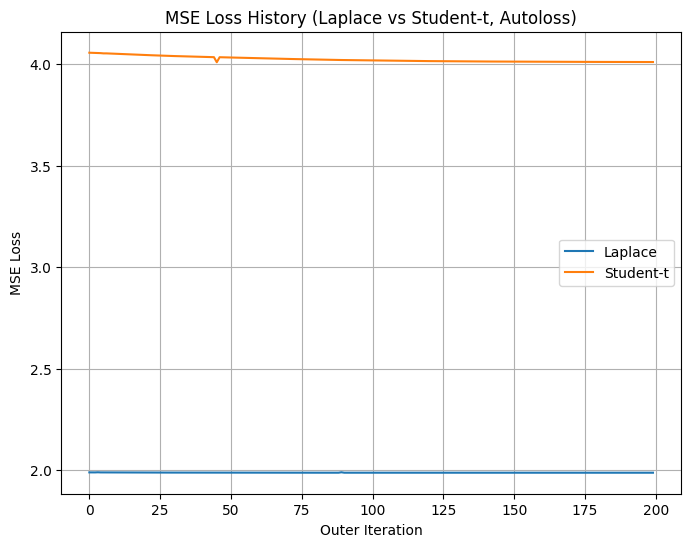

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\xinby\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\xinby\AppData\Local\Temp\ipykernel_3404\2553869150.py", line 382, in <module>
    main()
  File "C:\Users\xinby\AppData\Local\Temp\ipykernel_3404\2553869150.py", line 376, in main
    plot_theoretical_autoloss(U_st, V_st, S_st, T_st, tau_st, r_min=-5, r_max=5, num_points=100)
  File "C:\Users\xinby\AppData\Local\Temp\ipykernel_3404\2553869150.py", line 271, in plot_theoretical_autoloss
    L_np = L_tensor.cpu().numpy()
           ^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\xinby\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py",

In [ ]:
import torch
from qpth.qp import QPFunction
import matplotlib.pyplot as plt
import numpy as np
############################
# 1) QP+Autoloss 模块
############################

def build_qp_matrices(U, V, S, T, tau, X, y, lambda_reg):
    """
    构建Q, p, G, h，用于内层QP：
      minimize 0.5 * [beta^T * diag(lambda_reg) * beta + theta^T theta + sigma^T sigma]
               + tau^T sigma
      subject to  pi_li >= U_l(...) + V_l, ...
    """
    n, d = X.shape
    L = U.shape[0]
    H = S.shape[0]
    
    total_vars = d + L*n + 2*H*n  # [beta, pi, theta, sigma]
    
    # 对角线Q
    Q_diag = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    Q_diag[:d] = lambda_reg
    Q_diag[d + L*n : d + L*n + H*n] = 1.0      # theta
    Q_diag[d + L*n + H*n : ] = 1.0            # sigma
    
    Q = torch.diag(Q_diag).unsqueeze(0)
    
    # p 向量
    p = torch.zeros(total_vars, dtype=X.dtype, device=X.device)
    p[d + L*n + H*n:] = tau.repeat(n)  # sigma部分
    p = p.unsqueeze(0)
    
    # 不等式约束 G z <= h
    G_rows = 2*L*n + 2*H*n + d
    G = torch.zeros(G_rows, total_vars, dtype=X.dtype, device=X.device)
    h_val = torch.zeros(G_rows, dtype=X.dtype, device=X.device)
    
    row_idx = 0
    
    # pi_li >= U_l * (y_i - x_i^T beta) + V_l
    for i in range(n):
        for l in range(L):
            G[row_idx, :d] = U[l] * X[i]
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = U[l]*y[i] + V[l]
            row_idx += 1
    
    # pi_li >= 0
    for i in range(n):
        for l in range(L):
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # theta_hi + sigma_hi >= S_h*(y_i - x_i^T beta) + T_h
    for i in range(n):
        for h_ in range(H):
            G[row_idx, :d] = S[h_] * X[i]
            G[row_idx, d + L*n + h_*n + i] = -1.0
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = S[h_]*y[i] + T[h_]
            row_idx += 1

    # sigma_hi >= 0
    for i in range(n):
        for h_ in range(H):
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # beta_j >= 0
    for j in range(d):
        G[row_idx, j] = -1.0
        h_val[row_idx] = 0.0
        row_idx += 1
    
    G = G.unsqueeze(0)
    h = h_val.unsqueeze(0)
    
    eps = 1e-4
    Q = Q + eps * torch.eye(total_vars, dtype=X.dtype, device=X.device).unsqueeze(0)
    
    return Q, p, G, h

def solve_inner_qpth(U, V, S, T, tau, X_train, y_train, lambda_reg):
    """
    内层 QP 求解, 返回beta_opt
    """
    Q, p, G, h = build_qp_matrices(U, V, S, T, tau, X_train, y_train, lambda_reg)
    z = QPFunction(verbose=False)(Q, p, G, h, torch.empty(0, device=X_train.device), torch.empty(0, device=X_train.device))
    d = X_train.shape[1]
    beta_opt = z[:, :d].squeeze(0)
    return beta_opt

def compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg):
    """
    给定超参数(U,V,S,T), 先解内层beta，再对外层loss=MSE做 backward
    """
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X, y, lambda_reg)
    n = X.shape[0]
    
    y_pred = X @ beta_opt
    loss_outer = (1.0 / n) * (y - y_pred).pow(2).sum()
    loss_outer.backward()
    
    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)
    
    # 清零
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()
    
    return {
        "beta_opt": beta_opt.detach().clone(),
        "loss": loss_outer.item(),
        "U_grad": U_grad,
        "V_grad": V_grad,
        "S_grad": S_grad,
        "T_grad": T_grad
    }

def train_hyperparams(X, y, U, V, S, T, tau, lambda_reg,
                      lr=1e-2, outer_steps=50):
    """
    外层多步迭代, 手动梯度下降更新 U,V,S,T
    """
    loss_history = []
    for step in range(outer_steps):
        results = compute_outer_gradients(X, y, U, V, S, T, tau, lambda_reg)
        loss_val = results["loss"]
        U_grad, V_grad = results["U_grad"], results["V_grad"]
        S_grad, T_grad = results["S_grad"], results["T_grad"]
        
        with torch.no_grad():
            U -= lr * U_grad
            V -= lr * V_grad
            S -= lr * S_grad
            T -= lr * T_grad
        
        U.requires_grad_(True)
        V.requires_grad_(True)
        S.requires_grad_(True)
        T.requires_grad_(True)
        
        loss_history.append(loss_val)
        if (step+1) % 10 == 0:
            print(f"[outer step {step+1}/{outer_steps}] MSE loss = {loss_val:.6f}")
    
    return U, V, S, T, loss_history

############################
# 2) OLS 解(可加Ridge)
############################
def solve_ols(X, y, lambda_reg=0.0):
    """
    计算最简单的 OLS 带L2正则闭式解: (X^T X + lambdaI)^(-1) X^T y
    """
    n, d = X.shape
    A = X.t() @ X
    A = A + lambda_reg * torch.eye(d, device=X.device, dtype=X.dtype)
    b = X.t() @ y
    beta_ols = torch.linalg.solve(A, b)
    return beta_ols

############################
# 3) 评估 & 可视化
############################
def evaluate_and_print(X, y, beta_est, beta_true, label=""):
    """
    在 (X, y) 上用 beta_est 做预测, 打印 MSE/MAE, 并可对比 beta_true
    """
    with torch.no_grad():
        y_pred = X.matmul(beta_est)
        mse = ((y_pred - y)**2).mean().item()
        mae = (y_pred - y).abs().mean().item()
        print(f"{label} MSE: {mse:.6f}")
        print(f"{label} MAE: {mae:.6f}")
        if beta_true is not None:
            beta_mse = ((beta_est - beta_true)**2).mean().item()
            beta_mae = (beta_est - beta_true).abs().mean().item()
            print(f"{label} Beta MSE: {beta_mse:.6f}, Beta MAE: {beta_mae:.6f}")

def plot_loss_history(history_dict, title="Autoloss Outer Steps"):
    """
    绘制若干实验的外层训练损失曲线
    """
    plt.figure(figsize=(8,6))
    for k, val in history_dict.items():
        plt.plot(val, label=k)
    plt.xlabel("Outer Iteration")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

############################
# 4) 计算并可视化损失函数
############################
def reHU_piecewise(x, gamma):
    r"""
    实现分段函数 ReHU_gamma(x):
       = 0,                                       if x <= 0
       = 0.5 * x^2,                               if 0 < x < gamma
       = (x^2)/4 + (gamma*x)/2 - (gamma^2)/4,      if x >= gamma

    其中:
        x, gamma: 标量或张量；用 torch.where 做分段拼接
    """
    cond0 = (x <= 0)
    cond2 = (x >= gamma)
    
    val0 = torch.zeros_like(x)                           # x <= 0
    val1 = 0.5 * x**2                                    # 0 < x < gamma
    val2 = (x**2)/4 + 0.5*gamma*x - (gamma**2)/4         # x >= gamma
    
    out = torch.where(cond0, val0, val1)
    out = torch.where(cond2, val2, out)
    return out

def theoretical_autoloss(r, U, V, S, T, gamma):
    r"""
    单变量 r 的 Autoloss 理论函数:
       L(r) = sum_{l=1}^L ReLU(u_l * r + v_l)  +  sum_{h=1}^H ReHU_gamma_h(s_h * r + t_h).
    """
    # 把 r、U、V、S、T、gamma 全都变成 torch.Tensor
    # 这里演示用 CPU 计算即可
    device = U.device
    if not isinstance(r, torch.Tensor):
        r = torch.tensor(r, dtype=U.dtype, device=device)
    if r.dim() == 0:
        r = r.unsqueeze(0)
    
    # 计算 \sum_l ReLU(u_l * r + v_l)
    r_vals = r.unsqueeze(0)                           # => shape [1, N]
    uv = U.unsqueeze(1)*r_vals + V.unsqueeze(1)       # => [L, N]
    partL = torch.relu(uv).sum(dim=0)                 # => [N]

    # 计算 \sum_h ReHU_gamma_h(s_h * r + t_h)
    st = S.unsqueeze(1)*r_vals + T.unsqueeze(1)       # => [H, N]
    gamma_b = gamma.unsqueeze(1).expand_as(st)        # => [H, N]
    partH = reHU_piecewise(st, gamma_b).sum(dim=0)    # => [N]

    return partL + partH  # shape [N]

def plot_theoretical_autoloss(U, V, S, T, gamma, r_min=-5, r_max=5, num_points=100):
    r"""
    在区间 [r_min, r_max] 上采样 num_points 个点 r_k，
    并绘制 "理论 Autoloss 函数" L(r) = sum_l ReLU(...) + sum_h ReHU(...).
    """
    # 1) 构造 numpy 数组 r
    r_np = np.linspace(r_min, r_max, num_points)
    
    # 2) 转成 tensor 计算 L(r)
    #    注意要与 U, V, S, T, gamma 在同一 device & dtype
    device = U.device
    r_tensor = torch.tensor(r_np, dtype=U.dtype, device=device)
    L_tensor = theoretical_autoloss(r_tensor, U, V, S, T, gamma)
    
    # 3) 转回 numpy 以便用 matplotlib 绘制
    L_np = L_tensor.cpu().numpy()
    
    # 4) 画图
    plt.figure(figsize=(8, 6))
    plt.plot(r_np, L_np, 'b-', linewidth=2, label='Theoretical Autoloss')
    
    # 添加原点坐标轴
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # 添加图形装饰
    plt.xlabel('r (residual)')
    plt.ylabel('Autoloss(r)')
    plt.title('Theoretical 1D Autoloss Function')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

############################
# 5) 主函数：在这里统一生成数据 & 调用
############################
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # ========== 生成两组数据: Laplace 和 Student-t ==========
    # 设置超参数
    n, d = 200, 3
    L, H = 2, 2
    lambda_reg = 0.1
    outer_steps = 200
    lr = 1e-1
    
    # (a) Laplace 数据
    print("\n==== Laplace Noise Data ====")
    torch.manual_seed(42)
    from torch.distributions import Laplace
    beta_true_lap = torch.rand(d, device=device) * 10
    X_lap = torch.randn(n, d, device=device)
    eps_lap = Laplace(0.0, 1.0).sample((n,)).to(device)  # scale=1
    y_lap = X_lap @ beta_true_lap + eps_lap
    
    # (b) Student-t 数据
    print("\n==== Student-t Noise Data ====")
    torch.manual_seed(123)
    from torch.distributions import StudentT
    beta_true_st = torch.rand(d, device=device) * 10
    X_st = torch.randn(n, d, device=device)
    eps_st = StudentT(df=3.0).sample((n,)).to(device)  # scale=1
    y_st = X_st @ beta_true_st + eps_st
    
    # ========== 分别训练Autoloss & 对比OLS ==========

    # 1) Laplace
    print("\n-- Train Autoloss on Laplace data --")
    U_lap = torch.randn(L, device=device, requires_grad=True)
    V_lap = torch.randn(L, device=device, requires_grad=True)
    S_lap = torch.randn(H, device=device, requires_grad=True)
    T_lap = torch.randn(H, device=device, requires_grad=True)
    tau_lap = torch.ones(H, device=device, requires_grad=False)

    U_lap, V_lap, S_lap, T_lap, lap_loss_hist = train_hyperparams(
        X_lap, y_lap, U_lap, V_lap, S_lap, T_lap, tau_lap,
        lambda_reg=lambda_reg, lr=lr, outer_steps=outer_steps
    )
    beta_autoloss_lap = solve_inner_qpth(U_lap, V_lap, S_lap, T_lap, tau_lap, X_lap, y_lap, lambda_reg)

    
    
    print("\n-- Evaluate Autoloss on Laplace data --")
    evaluate_and_print(X_lap, y_lap, beta_autoloss_lap, beta_true_lap, label="Autoloss(Laplace)")
    
    print("\n-- Solve & Evaluate OLS on Laplace data --")
    beta_ols_lap = solve_ols(X_lap, y_lap, lambda_reg=lambda_reg)
    evaluate_and_print(X_lap, y_lap, beta_ols_lap, beta_true_lap, label="OLS(Laplace)")


    # 2) Student-t
    print("\n-- Train Autoloss on Student-t data --")
    U_st = torch.randn(L, device=device, requires_grad=True)
    V_st = torch.randn(L, device=device, requires_grad=True)
    S_st = torch.randn(H, device=device, requires_grad=True)
    T_st = torch.randn(H, device=device, requires_grad=True)
    tau_st = torch.ones(H, device=device, requires_grad=False)
    
    U_st, V_st, S_st, T_st, st_loss_hist = train_hyperparams(
        X_st, y_st, U_st, V_st, S_st, T_st, tau_st,
        lambda_reg=lambda_reg, lr=lr, outer_steps=outer_steps
    )
    beta_autoloss_st = solve_inner_qpth(U_st, V_st, S_st, T_st, tau_st, X_st, y_st, lambda_reg)

    
    print("\n-- Evaluate Autoloss on Student-t data --")
    evaluate_and_print(X_st, y_st, beta_autoloss_st, beta_true_st, label="Autoloss(Student-t)")
    
    print("\n-- Solve & Evaluate OLS on Student-t data --")
    beta_ols_st = solve_ols(X_st, y_st, lambda_reg=lambda_reg)
    evaluate_and_print(X_st, y_st, beta_ols_st, beta_true_st, label="OLS(Student-t)")
    
    # ========== 绘制训练过程中Autoloss外层的MSE损失曲线 ==========
    hist_dict = {
        "Laplace": lap_loss_hist,
        "Student-t": st_loss_hist
    }
    plot_loss_history(hist_dict, title="MSE Loss History (Laplace vs Student-t, Autoloss)")
    plot_theoretical_autoloss(U_st, V_st, S_st, T_st, tau_st, r_min=-5, r_max=5, num_points=100)
    plot_theoretical_autoloss(U_lap, V_lap, S_lap, T_lap, tau_lap, r_min=-5, r_max=5, num_points=100)

    print("\nDone!")

if __name__ == "__main__":
    main()


In [28]:
def build_qp_matrices(U, V, S, T, tau, X_train, y_train, lambda_reg):
    """
    构建Q, p, G, h，用于内层QP：
      minimize 0.5 * [beta^T * diag(lambda_reg) * beta + theta^T theta + sigma^T sigma]
               + tau^T sigma
      subject to  pi_li >= U_l(...) + V_l, ...
    """
    n, d = X_train.shape
    L = U.shape[0]
    H = S.shape[0]
    
    total_vars = d + L*n + 2*H*n  # [beta, pi, theta, sigma]
    
    # 对角线Q
    Q_diag = torch.zeros(total_vars, dtype=X_train.dtype, device=X_train.device)
    Q_diag[:d] = lambda_reg
    Q_diag[d + L*n : d + L*n + H*n] = 1.0      # theta
    Q_diag[d + L*n + H*n : ] = 1.0            # sigma
    
    Q = torch.diag(Q_diag).unsqueeze(0)
    
    # p 向量
    p = torch.zeros(total_vars, dtype=X_train.dtype, device=X_train.device)
    p[d + L*n + H*n:] = tau.repeat(n)  # sigma部分
    p = p.unsqueeze(0)
    
    # 不等式约束 G z <= h
    G_rows = 2*L*n + 2*H*n + d
    G = torch.zeros(G_rows, total_vars, dtype=X_train.dtype, device=X_train.device)
    h_val = torch.zeros(G_rows, dtype=X_train.dtype, device=X_train.device)
    
    row_idx = 0
    
    # pi_li >= U_l * (y_i - x_i^T beta) + V_l
    for i in range(n):
        for l in range(L):
            G[row_idx, :d] = U[l] * X_train[i]
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = U[l]*y_train[i] + V[l]
            row_idx += 1
    
    # pi_li >= 0
    for i in range(n):
        for l in range(L):
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # theta_hi + sigma_hi >= S_h*(y_i - x_i^T beta) + T_h
    for i in range(n):
        for h_ in range(H):
            G[row_idx, :d] = S[h_] * X_train[i]
            G[row_idx, d + L*n + h_*n + i] = -1.0
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = S[h_]*y_train[i] + T[h_]
            row_idx += 1

    # sigma_hi >= 0
    for i in range(n):
        for h_ in range(H):
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # beta_j >= 0
    for j in range(d):
        G[row_idx, j] = -1.0
        h_val[row_idx] = 0.0
        row_idx += 1
    
    G = G.unsqueeze(0)
    h = h_val.unsqueeze(0)
    
    eps = 1e-4
    Q = Q + eps * torch.eye(total_vars, dtype=X_train.dtype, device=X_train.device).unsqueeze(0)
    
    return Q, p, G, h

def solve_inner_qpth(U, V, S, T, tau, X_train, y_train, lambda_reg):
    """
    内层 QP 求解, 返回beta_opt
    """
    Q, p, G, h = build_qp_matrices(U, V, S, T, tau, X_train, y_train, lambda_reg)
    z = QPFunction(verbose=False)(Q, p, G, h, torch.empty(0, device=X_train.device), torch.empty(0, device=X_train.device))
    d = X_train.shape[1]
    beta_opt = z[:, :d].squeeze(0)
    return beta_opt


def compute_outer_gradients(X_train, y_train, X_val, y_val , U, V, S, T, tau, lambda_reg):
    """
    给定超参数(U,V,S,T), 先解内层beta，再对外层loss=MSE做 backward
    """
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X_train, y_train, lambda_reg)
    
    n = X_val.shape[0]
    y_val_pred = X_val @ beta_opt
    loss_outer = (1.0 / n) * (y_val - y_val_pred).pow(2).sum()
    loss_outer.backward()
    
    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)
    
    # 清零
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()
    
    return {
        "beta_opt": beta_opt.detach().clone(),
        "loss": loss_outer.item(),
        "U_grad": U_grad,
        "V_grad": V_grad,
        "S_grad": S_grad,
        "T_grad": T_grad
    }

def train_hyperparams(X_train, y_train, X_val, y_val, U, V, S, T, tau, lambda_reg,
                      lr=1e-2, outer_steps=50):
    """
    外层多步迭代, 手动梯度下降更新 U,V,S,T
    """
    loss_history = []
    for step in range(outer_steps):
        results = compute_outer_gradients(X_train, y_train, X_val, y_val, U, V, S, T, tau, lambda_reg)
        loss_val = results["loss"]
        U_grad, V_grad = results["U_grad"], results["V_grad"]
        S_grad, T_grad = results["S_grad"], results["T_grad"]
        
        with torch.no_grad():
            U -= lr * U_grad
            V -= lr * V_grad
            S -= lr * S_grad
            T -= lr * T_grad
        
        U.requires_grad_(True)
        V.requires_grad_(True)
        S.requires_grad_(True)
        T.requires_grad_(True)
        
        loss_history.append(loss_val)
        if (step+1) % 10 == 0:
            print(f"[outer step {step+1}/{outer_steps}] MSE loss = {loss_val:.6f}")
    
    return U, V, S, T, loss_history

# ========== 生成: Laplace 
# 设置超超参数
n, d = 200, 5
L, H = 2, 2
lambda_reg = 0.1
outer_steps = 10
lr = 1e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# (a) Laplace 数据
print("\n==== Laplace Noise Data ====")
torch.manual_seed(42)
from torch.distributions import Laplace
beta_true_lap = torch.rand(d, device=device) * 10
X_lap = torch.randn(n, d, device=device)
eps_lap = Laplace(0.0, 1.0).sample((n,)).to(device)  # scale=1
y_lap = X_lap @ beta_true_lap + eps_lap

# 1) Laplace
print("\n-- Train Autoloss on Laplace data --")
U_lap = torch.randn(L, device=device, requires_grad=True)
V_lap = torch.randn(L, device=device, requires_grad=True)
S_lap = torch.randn(H, device=device, requires_grad=True)
T_lap = torch.randn(H, device=device, requires_grad=True)
tau_lap = torch.ones(H, device=device, requires_grad=False)

# 2) Train-Val Split
N_train = 150
X_lap_train, y_lap_train = X_lap[:N_train], y_lap[:N_train]
X_lap_val, y_lap_val = X_lap[N_train:], y_lap[N_train:]

for iter in range(20):
    print(f"\n--- Laplace Iteration {iter+1} ---")
    U_lap, V_lap, S_lap, T_lap, lap_loss_hist = train_hyperparams(
        X_lap_train, y_lap_train, X_lap_val, y_lap_val,
        U_lap, V_lap, S_lap, T_lap, tau_lap,
        lambda_reg=lambda_reg, lr=lr, outer_steps=outer_steps
    )

    beta_autoloss_lap = solve_inner_qpth(U_lap, V_lap, S_lap, T_lap, tau_lap, 
                                            X_lap_train, y_lap_train, lambda_reg)
    
    evaluate_and_print(X_lap_val, y_lap_val, beta_autoloss_lap, beta_true_lap, label="Val Autoloss(Laplace)")
    evaluate_and_print(X_lap_train, y_lap_train, beta_autoloss_lap, beta_true_lap, label="Train Autoloss(Laplace)")





    

Using device: cuda

==== Laplace Noise Data ====

-- Train Autoloss on Laplace data --

--- Laplace Iteration 1 ---
[outer step 10/10] MSE loss = 1.147810
Val Autoloss(Laplace) MSE: 1.147461
Val Autoloss(Laplace) MAE: 0.761749
Val Autoloss(Laplace) Beta MSE: 0.041236, Beta MAE: 0.165974
Train Autoloss(Laplace) MSE: 2.374356
Train Autoloss(Laplace) MAE: 1.123015
Train Autoloss(Laplace) Beta MSE: 0.041236, Beta MAE: 0.165974

--- Laplace Iteration 2 ---
[outer step 10/10] MSE loss = 1.144650
Val Autoloss(Laplace) MSE: 1.144608
Val Autoloss(Laplace) MAE: 0.760095
Val Autoloss(Laplace) Beta MSE: 0.040721, Beta MAE: 0.166360
Train Autoloss(Laplace) MSE: 2.371023
Train Autoloss(Laplace) MAE: 1.121967
Train Autoloss(Laplace) Beta MSE: 0.040721, Beta MAE: 0.166360

--- Laplace Iteration 3 ---
[outer step 10/10] MSE loss = 1.142888
Val Autoloss(Laplace) MSE: 1.142743
Val Autoloss(Laplace) MAE: 0.758937
Val Autoloss(Laplace) Beta MSE: 0.040346, Beta MAE: 0.166572
Train Autoloss(Laplace) MSE: 2.3

In [27]:
print(f"beta_true_lap: {beta_true_lap}")
print(f"beta_autoloss_lap: {beta_autoloss_lap}")

beta_true_lap: tensor([6.1296, 0.1006, 3.9841], device='cuda:0')
beta_autoloss_lap: tensor([ 6.2370e+00, -4.6342e-09,  3.9436e+00], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


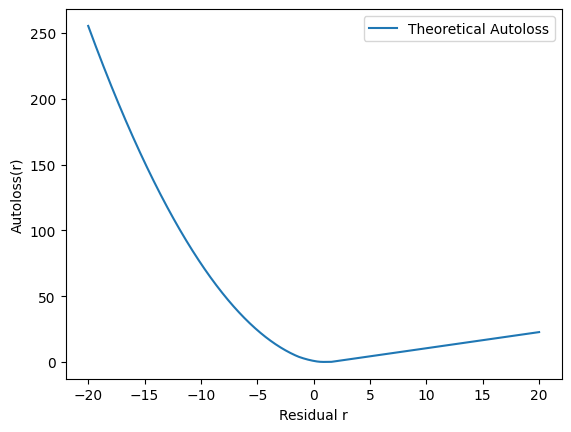

In [31]:
# plot the autoloss function
x = torch.linspace(-20, 20, 1000, device=device)
y = theoretical_autoloss(x, U_lap, V_lap, S_lap, T_lap, tau_lap)
plt.plot(x.cpu().detach().numpy(), y.cpu().detach().numpy(), label="Theoretical Autoloss")
plt.xlabel("Residual r")
plt.ylabel("Autoloss(r)")
plt.legend()